### **ROSSMAN STORE DATASET**

You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

**Files**

    train.csv - historical data including Sales
    test.csv - historical data excluding Sales
    sample_submission.csv - a sample submission file in the correct format
    store.csv - supplemental information about the stores

**Data fields**

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

*    Id - an Id that represents a (Store, Date) duple within the test set
*    Store - a unique Id for each store
*    Sales - the turnover for any given day (this is what you are predicting)
*    Customers - the number of customers on a given day
*    Open - an indicator for whether the store was open: 0 = closed, 1 = open
*    StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
*    SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
*    StoreType - differentiates between 4 different store models: a, b, c, d
*    Assortment - describes an assortment level: a = basic, b = extra, c = extended
*    CompetitionDistance - distance in meters to the nearest competitor store
*    CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
*    Promo - indicates whether a store is running a promo on that day
*    Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
*    Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
*    PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


In [ ]:
import time
import itertools
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
####################################################################################################
# HELPER FUNCTIONS (UTILS)
####################################################################################################
# Check dataframe
def check_df(dataframe, head=5, tail=5, quan=False):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(tail))
    print("################# Unique Values #################")
    print(dataframe.nunique())
    print("##################### NA #####################")
    print(dataframe.isnull().sum())

    if quan:
        print("##################### Quantiles #####################")
        print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

# Date Features
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

# Random Noise
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

# Lag/Shifted Features
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "promo"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

# Rolling Mean Features
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "promo"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

# Exponentially Weighted Mean Features
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "promo"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

# Custom Cost Function
def mae(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    
    mae_val = (np.sum(num)) / n
    return mae_val

def lgbm_mae(preds, train_data):
    labels = train_data.get_label()
    mae_val = mae(np.expm1(preds), np.expm1(labels))
    return 'MAE',   mae_val, False

# Feature Importance
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))

#############################################
# MISSING VALUES
#############################################

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")


In [ ]:
# Mount Google drive to collaboratory
from google.colab import drive 
drive.mount('/content/gdrive')

KeyboardInterrupt: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Load data
train_df = pd.read_csv('gdrive/My Drive/train.csv', parse_dates=['Date'])
test_df = pd.read_csv('gdrive/My Drive/test.csv', parse_dates=['Date'])


In [ ]:
# Load data
train_df = pd.read_csv('train.csv', parse_dates=['Date'])
test_df = pd.read_csv('test.csv', parse_dates=['Date'])
store_df = pd.read_csv('store.csv')

In [ ]:
store_df = pd.read_csv('gdrive/My Drive/store.csv')

#### **1.EXPLORATORY DATA ANALYSIS**

In [ ]:
train_df["Date"].min(), train_df["Date"].max()  

(Timestamp('2013-01-01 00:00:00'), Timestamp('2015-07-31 00:00:00'))

In [ ]:
test_df["Date"].min(), test_df["Date"].max()  

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [ ]:
check_df(train_df)

##################### Shape #####################
(840445, 9)
##################### Types #####################
Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Sales                   float64
Customers               float64
Open                    float64
Promo                   float64
StateHoliday             object
SchoolHoliday           float64
dtype: object
##################### Head #####################
   Store  DayOfWeek       Date    Sales  Customers  Open  Promo StateHoliday  SchoolHoliday
0      1          5 2015-07-31   5263.0      555.0   1.0    1.0            0            1.0
1      2          5 2015-07-31   6064.0      625.0   1.0    1.0            0            1.0
2      3          5 2015-07-31   8314.0      821.0   1.0    1.0            0            1.0
3      4          5 2015-07-31  13995.0     1498.0   1.0    1.0            0            1.0
4      5          5 2015-07-31   4822.0      559.0   1.0    1.0            0 

In [ ]:
check_df(test_df)

##################### Shape #####################
(41088, 8)
##################### Types #####################
Id                        int64
Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Open                    float64
Promo                     int64
StateHoliday             object
SchoolHoliday             int64
dtype: object
##################### Head #####################
   Id  Store  DayOfWeek       Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4 2015-09-17   1.0      1            0              0
1   2      3          4 2015-09-17   1.0      1            0              0
2   3      7          4 2015-09-17   1.0      1            0              0
3   4      8          4 2015-09-17   1.0      1            0              0
4   5      9          4 2015-09-17   1.0      1            0              0
##################### Tail #####################
          Id  Store  DayOfWeek       Date  Open  Promo StateHolid

In [ ]:
check_df(store_df)

##################### Shape #####################
(1115, 10)
##################### Types #####################
Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object
##################### Head #####################
   Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear    PromoInterval
0      1         c          a               1270.0                        9.0                    2008.0       0              NaN              NaN              NaN
1      2         a          a                570.0                       11.0                    2007.0       1             13.0  

**Missing value analysis:** 

* There are 11 NA values in "Open" feature in test set. Let's observe them.

In [ ]:
# Observe NaN values
test_df[test_df.isnull().any(axis=1)]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


**NOTE:** As there is no state holiday or school holiday, this means that the store is open, so we can fill NA values with 1. 

In [ ]:
test_df["Open"].fillna(1, inplace=True)

In [ ]:
# We have NaN values in store 
# Check missing values and their ratios
missing_values_table(store_df, na_name=False)

                           n_miss  ratio
PromoInterval                 544  48.79
Promo2SinceYear               544  48.79
Promo2SinceWeek               544  48.79
CompetitionOpenSinceYear      354  31.75
CompetitionOpenSinceMonth     354  31.75
CompetitionDistance             3   0.27


In [ ]:
# Observe missing values of "Promo2SinceWeek"
store_df[store_df['Promo2SinceWeek'].isnull()].head(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
22,23,d,a,4060.0,8.0,2005.0,0,NaN,NaN,NaN


In [ ]:
# I think "Promo2SinceWeek", "Promo2SinceYear" and "PromoInterval" are empty because Promo2 == 0 
# Let's check this
(store_df[store_df['Promo2SinceWeek'].isnull()]['Promo2'] == 0).sum()
# Yes, that's the reason. 
# We can fill NA values of "Promo2SinceWeek", "Promo2SinceYear" and "PromoInterval" with zero. 

In [ ]:
# Fill NA values of "Promo2SinceWeek", "Promo2SinceYear" and "PromoInterval" with zero. 
store_df["Promo2SinceWeek"].fillna(0, inplace=True)
store_df["Promo2SinceYear"].fillna(0, inplace=True)
store_df["PromoInterval"].fillna(0, inplace=True)

In [ ]:
# Re-check
missing_values_table(store_df, na_name=False)

                           n_miss  ratio
CompetitionOpenSinceYear      354  31.75
CompetitionOpenSinceMonth     354  31.75
CompetitionDistance             3   0.27


In [ ]:
# Observe missing values of "CompetitionOpenSinceMonth"
store_df[store_df['CompetitionOpenSinceMonth'].isnull()].tail(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1079,1080,a,a,2410.0,NaN,NaN,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
1082,1083,d,c,11540.0,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"
1083,1084,a,a,190.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
1089,1090,a,a,330.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1090,1091,a,c,9990.0,NaN,NaN,0,0.0,0.0,0
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,0.0,0.0,0
1113,1114,a,c,870.0,NaN,NaN,0,0.0,0.0,0
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [ ]:
store_df.groupby(['Store', 'StoreType']).agg({'CompetitionDistance': 'mean'}).tail()

,,CompetitionDistance
Store,StoreType,
1111,a,1900.0
1112,c,1880.0
1113,a,9260.0
1114,a,870.0
1115,d,5350.0


In [ ]:
store_df[store_df['CompetitionOpenSinceMonth'].isnull()].groupby(['Store', 'StoreType']).agg({'CompetitionDistance': 'mean'}).tail()

,,CompetitionDistance
Store,StoreType,
1096,a,1130.0
1100,a,540.0
1113,a,9260.0
1114,a,870.0
1115,d,5350.0


#### **NOTE:** I could'nt get any insight on how to fill NA values of "CompetitionOpenSinceMonth".
#### I will visualize the feature and check again

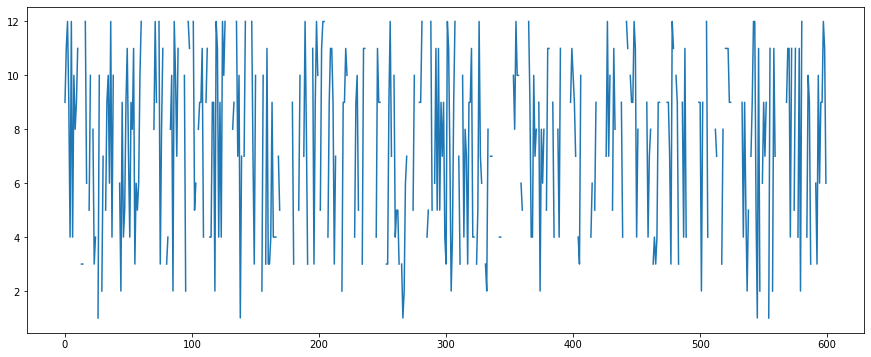

In [ ]:
store_df['CompetitionOpenSinceMonth'][0:600].plot(figsize=(15, 6));

In [ ]:
store_df['CompetitionOpenSinceMonth'].describe().T

count    761.000000
mean       7.224704
std        3.212348
min        1.000000
25%        4.000000
50%        8.000000
75%       10.000000
max       12.000000
Name: CompetitionOpenSinceMonth, dtype: float64

In [ ]:
# Check the mode of CompetitionOpenSinceMonth
from scipy import stats
stats.mode(store_df['CompetitionOpenSinceMonth'])[0][0]

9.0

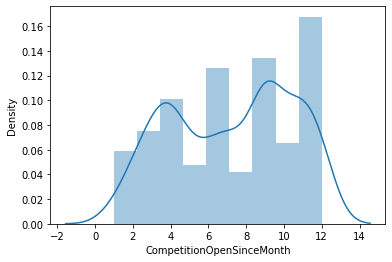

In [ ]:
# Check the plot
sns.distplot(store_df.CompetitionOpenSinceMonth);

In [ ]:
# We can fill NA values with mode 
store_df["CompetitionOpenSinceMonth"].fillna(9, inplace=True)

In [ ]:
# Observe missing values of "CompetitionOpenSinceYear"
store_df[store_df['CompetitionOpenSinceYear'].isnull()].tail(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1079,1080,a,a,2410.0,9.0,NaN,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
1082,1083,d,c,11540.0,9.0,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"
1083,1084,a,a,190.0,9.0,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
1089,1090,a,a,330.0,9.0,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1090,1091,a,c,9990.0,9.0,NaN,0,0.0,0.0,0
1095,1096,a,c,1130.0,9.0,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,9.0,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,9.0,NaN,0,0.0,0.0,0
1113,1114,a,c,870.0,9.0,NaN,0,0.0,0.0,0
1114,1115,d,c,5350.0,9.0,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


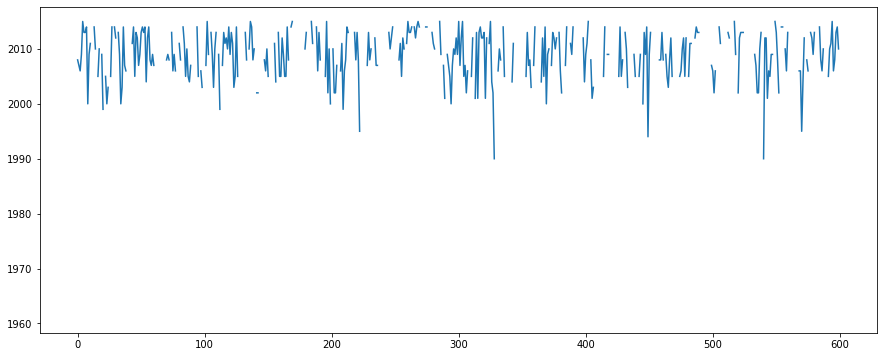

In [ ]:
store_df['CompetitionOpenSinceYear'][0:600].plot(figsize=(15, 6));

In [ ]:
store_df['CompetitionOpenSinceYear'].describe().T

count     761.000000
mean     2008.668857
std         6.195983
min      1900.000000
25%      2006.000000
50%      2010.000000
75%      2013.000000
max      2015.000000
Name: CompetitionOpenSinceYear, dtype: float64

In [ ]:
# Check the mode of CompetitionOpenSinceMonth
stats.mode(store_df['CompetitionOpenSinceYear'])[0][0]

2013.0

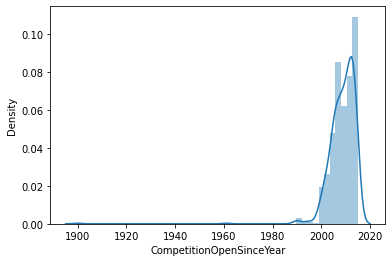

In [ ]:
# Check the plot 
sns.distplot(store_df.CompetitionOpenSinceYear);

In [ ]:
# We can fill NA values with mode 
store_df["CompetitionOpenSinceYear"].fillna(2013, inplace=True)

In [ ]:
# Observe NaN values of 'CompetitionDistance'
store_df[store_df['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,9.0,2013.0,0,0.0,0.0,0
621,622,a,c,NaN,9.0,2013.0,0,0.0,0.0,0
878,879,d,a,NaN,9.0,2013.0,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [ ]:
store_df['CompetitionDistance'].describe().T

count     1112.000000
mean      5404.901079
std       7663.174720
min         20.000000
25%        717.500000
50%       2325.000000
75%       6882.500000
max      75860.000000
Name: CompetitionDistance, dtype: float64

In [ ]:
# Check the mode of CompetitionDistance
stats.mode(store_df['CompetitionDistance'])[0][0]

250.0

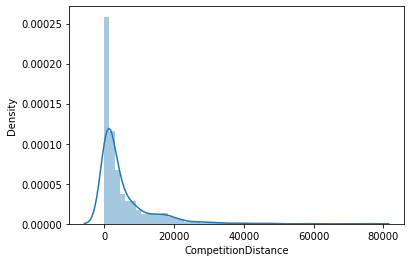

In [ ]:
# Check the plot 
sns.distplot(store_df.CompetitionDistance);

In [ ]:
# It makes sense to fill with mode
store_df["CompetitionDistance"].fillna(250, inplace=True)

In [ ]:
# Final check for missing values
missing_values_table(store_df, na_name=False)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


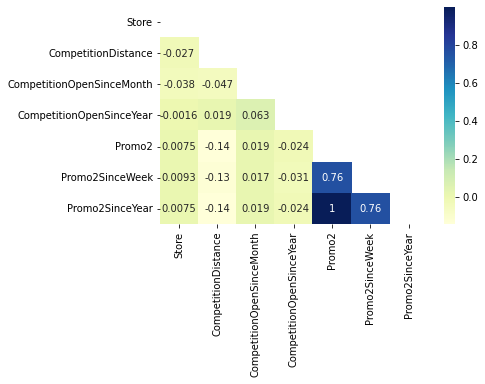

In [ ]:
# Check the correlation matrix (store)
mask = np.triu(np.ones_like(store_df.corr().round(2)))
dataplot = sns.heatmap(store_df.corr(), cmap="YlGnBu", annot=True, mask=mask)
plt.show()

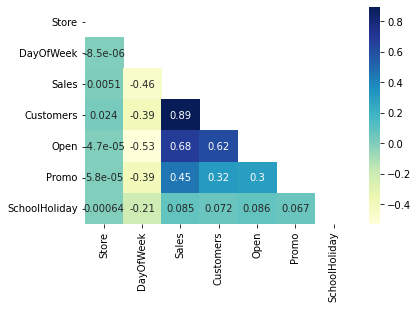

In [ ]:
# Check the correlation matrix (train)
mask = np.triu(np.ones_like(train_df.corr().round(2)))
dataplot = sns.heatmap(train_df.corr(), cmap="YlGnBu", annot=True, mask=mask)
plt.show()

#### **NOTE:** There is no need to drop any features for now. We can check again after pre-processing is completed.

#### **2. DATA VISUALIZATION**

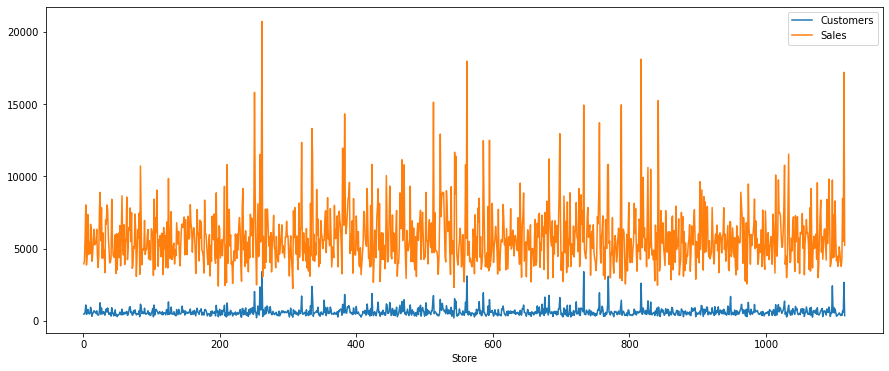

In [ ]:
# Mean of Sales and Customers as per Store
train_df.groupby('Store').agg({'Customers': 'mean', 'Sales': 'mean'}).plot(figsize=(15, 6));

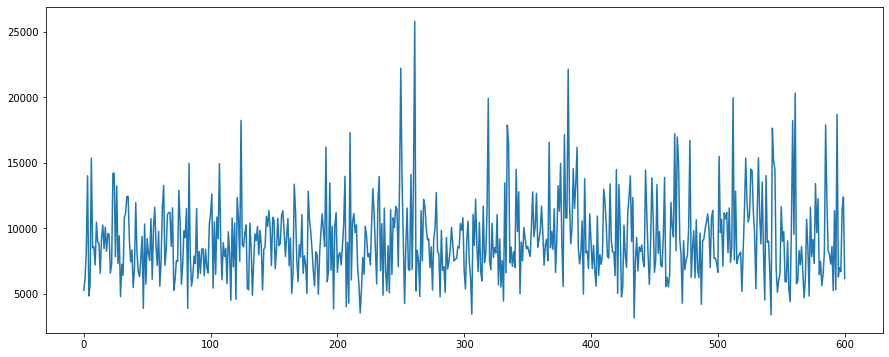

In [ ]:
# What is the situation when the Store is open and there is a Promo
train_df[(train_df.Open == 1) & (train_df.Promo == 1)]['Sales'][0:600].plot(figsize=(15,6));

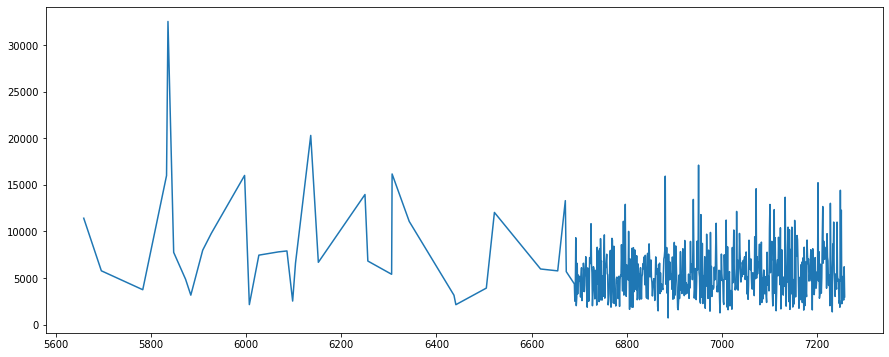

In [ ]:
# What is the situation when the Store is open and there is no Promo
train_df[(train_df.Open == 1) & (train_df.Promo == 0)]['Sales'][0:600].plot(figsize=(15,6));

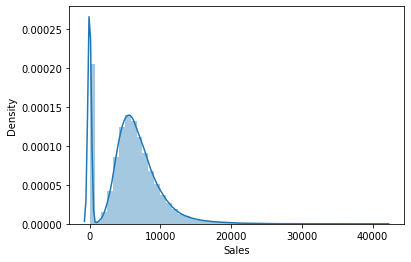

In [ ]:
sns.distplot(train_df.Sales);

In [ ]:
train_df.StateHoliday.value_counts()    ####################### 0 lar farkli formatta geliyor  $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [ ]:
train_df.replace({"StateHoliday":0},{"StateHoliday":"0"},inplace=True)

In [ ]:
train_df.dtypes

Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday             object
SchoolHoliday             int64
dtype: object

In [ ]:
test_df.StateHoliday.value_counts()

0    40908
a      180
Name: StateHoliday, dtype: int64

In [ ]:
test_df[test_df.StateHoliday=='0']  # value type in test is str 

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [ ]:
# Are all stores closed when it is a holiday? 
(train_df[(train_df.StateHoliday == 1) | (train_df.SchoolHoliday == 1)].Open == 1).sum()
# 163.457 stores are open on one of the holidays

163457

<Figure size 432x288 with 0 Axes>

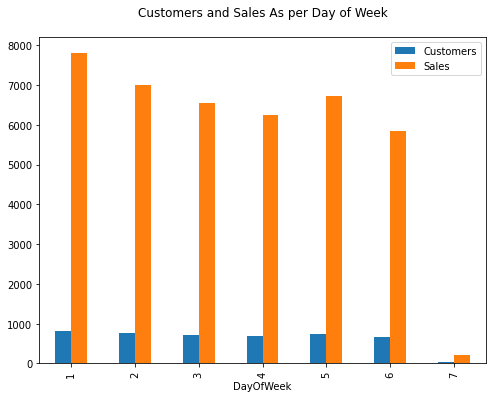

In [ ]:
# Define the dataframe to be plotted 
dow = train_df.groupby('DayOfWeek').agg({'Customers': 'mean', 'Sales': 'mean'})
plt.figure()
dow.plot(kind='bar', figsize=(8,6))
plt.title('Customers and Sales As per Day of Week\n')
plt.legend();

#### **NOTE:** On mondays Sales amount has its highest value. On Friday, it increase again. On Sunday it is very small. Stores may be closed on Sunday. Let's check it 

In [ ]:
(train_df[train_df.DayOfWeek ==7].Open == 1).sum()
# There are 3593 stores that are open in Sunday

3593

In [ ]:
train_df.dtypes

Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday             object
SchoolHoliday             int64
dtype: object

<Figure size 432x288 with 0 Axes>

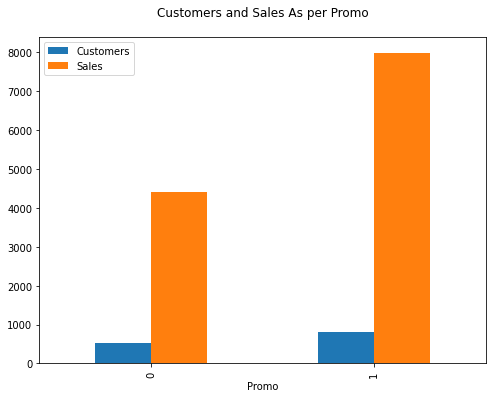

In [ ]:
# Visualize Promo feature 
promo_df= train_df.groupby('Promo').agg({'Customers': 'mean', 'Sales': 'mean'})

plt.figure()
promo_df.plot(kind='bar', figsize=(8,6))
plt.title('Customers and Sales As per Promo\n')
plt.legend();

<Figure size 432x288 with 0 Axes>

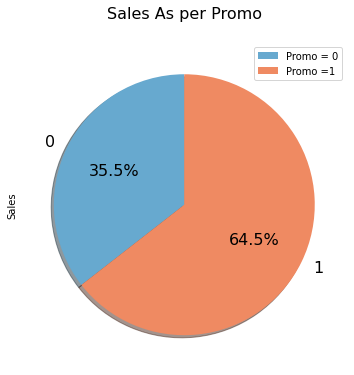

In [ ]:
# Visualize Promo feature 
promo_df2= train_df.groupby('Promo').agg({'Sales': 'mean'})
names = ['Promo = 0', 'Promo =1']

plt.figure()
promo_df2.plot(kind='pie', figsize=(8,6), subplots=True, autopct='%1.1f%%', 
               shadow=True, startangle=90, fontsize=16, colors=('#67a9cf','#ef8a62'))
plt.title('Sales As per Promo\n', fontsize=16)
plt.legend(names)
plt.rcParams["figure.figsize"] = [10,10]
plt.show();

<Figure size 720x720 with 0 Axes>

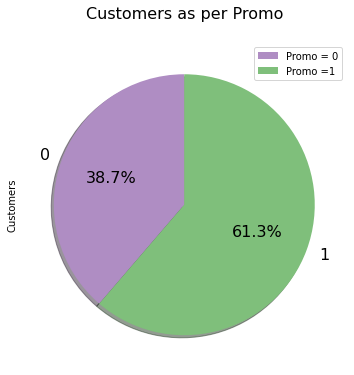

In [ ]:
# Visualize Promo feature (Customers)
promo_df3= train_df.groupby('Promo').agg({'Customers': 'mean'})
names = ['Promo = 0', 'Promo =1']

plt.figure()
promo_df3.plot(kind='pie', figsize=(8,6), subplots=True, autopct='%1.1f%%', 
               shadow=True, startangle=90, fontsize=16, colors=('#af8dc3','#7fbf7b'))
plt.title('Customers as per Promo\n', fontsize=16)
plt.legend(names)
plt.rcParams["figure.figsize"] = [10,10]
plt.show();

<Figure size 720x720 with 0 Axes>

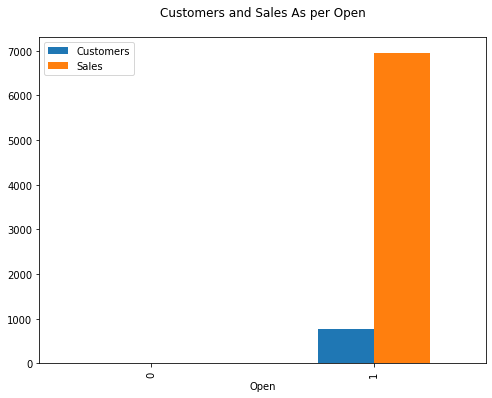

In [ ]:
# Visualize Open feature 
open_df= train_df.groupby('Open').agg({'Customers': 'mean', 'Sales': 'mean'})

plt.figure()
open_df.plot(kind='bar', figsize=(8,6))
plt.title('Customers and Sales As per Open\n')
plt.legend();

In [ ]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


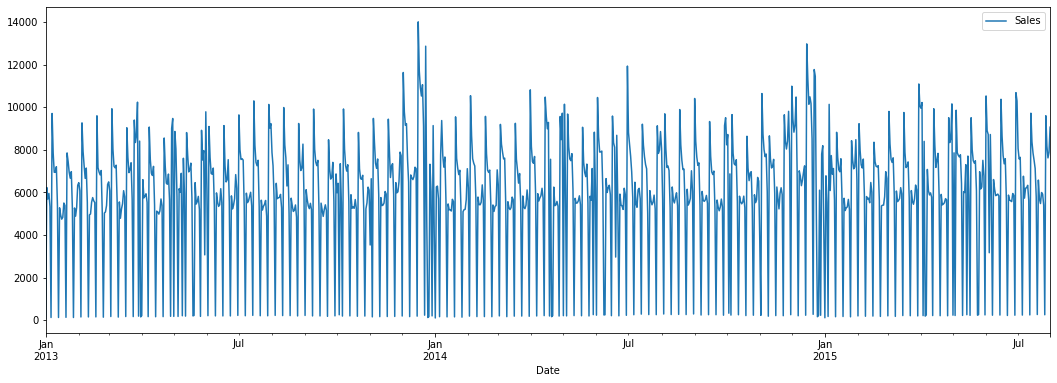

In [ ]:
# Sales according to date (Train)
train_df.groupby('Date').agg({'Sales': 'mean'}).plot(figsize=(18, 6));

In [ ]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [ ]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
# Merge store and train datasets
train_store = pd.merge(train_df, store_df, how = 'inner', on = 'Store')
train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [ ]:
# Checking missing values
missing_values_table(train_store, na_name=False)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


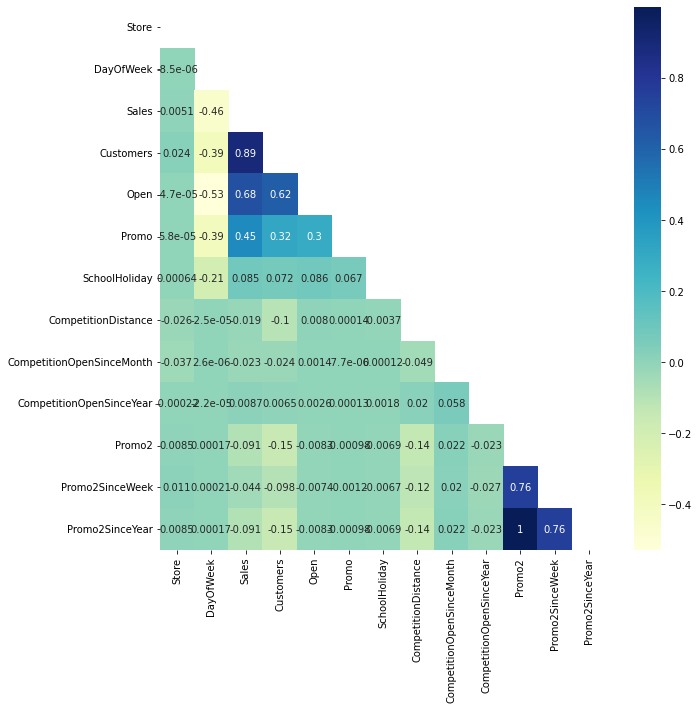

In [ ]:
# Check the correlation matrix (store)
mask = np.triu(np.ones_like(train_store.corr().round(2)))
dataplot = sns.heatmap(train_store.corr(), cmap="YlGnBu", annot=True, mask=mask)
plt.show()

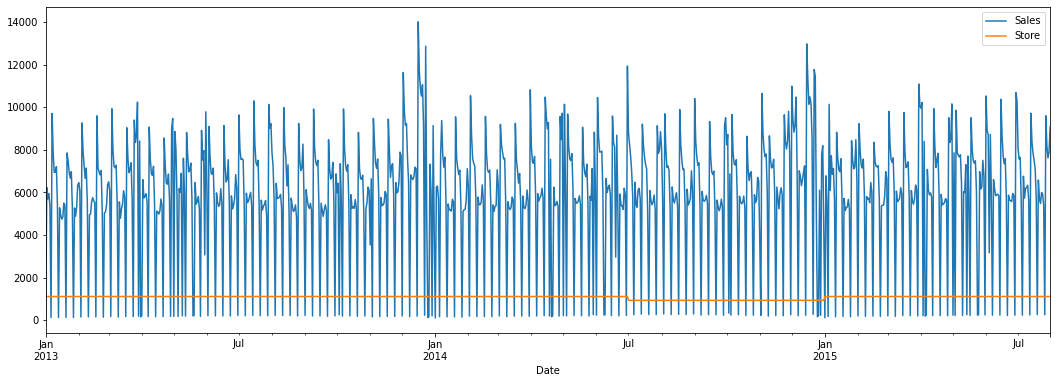

In [ ]:
# Now we can plot Sales according to stores
train_store.groupby('Date').agg({'Sales': 'mean', 'Store': 'count'}).plot(figsize=(18, 6));

#### **NOTE:** There is a slight decrease of the number of stores between Jul'14 to Jan'15. Let's check in detail to find the reasons of this decrease. I will plot sales per storetype in order to get an insight.

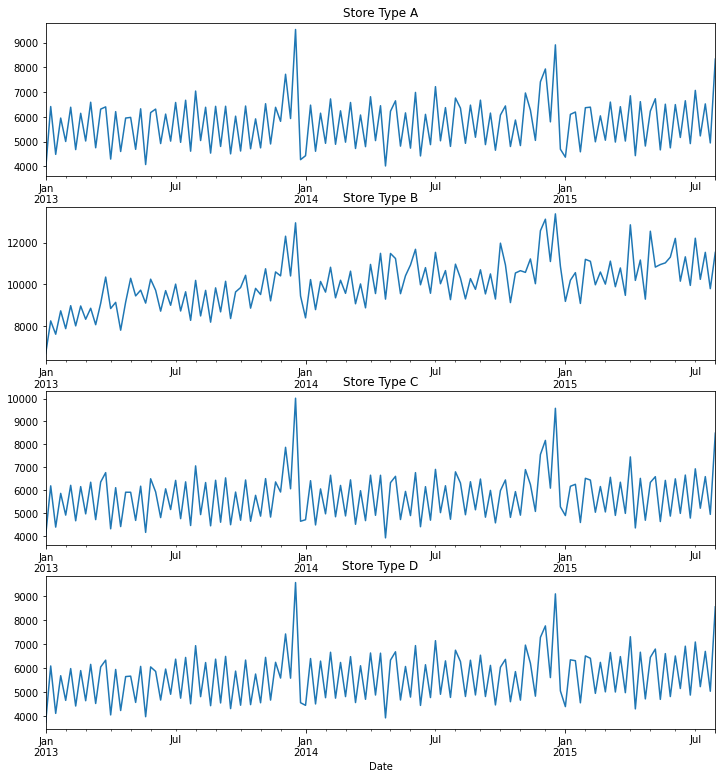

In [ ]:
# In order to observe better, let's convert the data to weekly form and then plot for each store type

# Assign seperate dataframes for each store type
a_store = train_store[train_store['StoreType']=='a']
b_store = train_store[train_store['StoreType']=='b']
c_store = train_store[train_store['StoreType']=='c']
d_store = train_store[train_store['StoreType']=='d']

# Set index as 'Date'
a_store.set_index('Date', inplace =True)
b_store.set_index('Date', inplace =True)
c_store.set_index('Date', inplace =True)
d_store.set_index('Date', inplace =True)

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# Weekly resample
a_store['Sales'].resample('W').mean().plot(ax = ax1, title='Store Type A')
b_store['Sales'].resample('W').mean().plot(ax = ax2, title='Store Type B')
c_store['Sales'].resample('W').mean().plot(ax = ax3, title='Store Type C')
d_store['Sales'].resample('W').mean().plot(ax = ax4, title='Store Type D');

#### **NOTE:** When we check the plots for each store type we can see that sales of Store Type B is different from others. Because there is no zero sales and the amount of sales is higher than the other stores. However, we need to check total sales also to see the exact situation (Please see Feature Engineering part). 

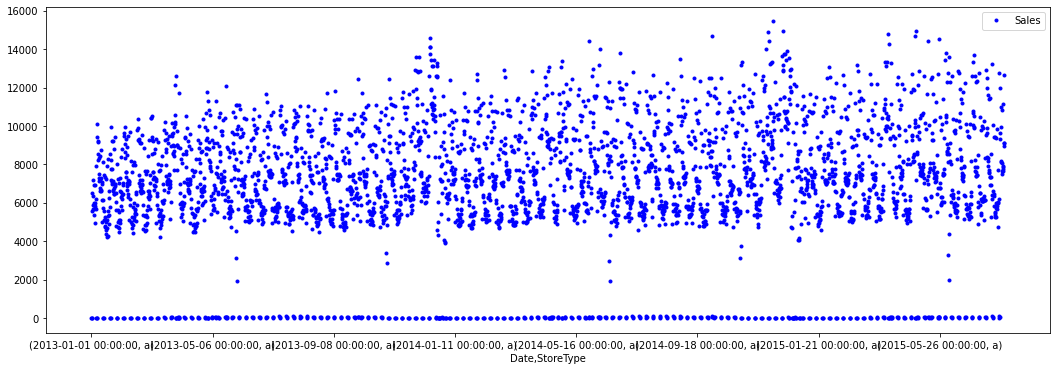

In [ ]:
# Let's check the dot plot: 
train_store.groupby(['Date', 'StoreType']).agg({'Sales': 'mean'}).plot(style = 'b.', figsize=(18, 6));

#### It is interesting to see the zero sales in the dot plot. This was not very clear on the line plot.

In [ ]:
# Let's observe the zero sales: 
zero_sales = train_store[train_store['Sales']== 0]
zero_sales.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
5,1,7,2015-07-26,0,0,0,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
12,1,7,2015-07-19,0,0,0,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
19,1,7,2015-07-12,0,0,0,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
26,1,7,2015-07-05,0,0,0,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
33,1,7,2015-06-28,0,0,0,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [ ]:
zero_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172871 entries, 5 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      172871 non-null  int64         
 1   DayOfWeek                  172871 non-null  int64         
 2   Date                       172871 non-null  datetime64[ns]
 3   Sales                      172871 non-null  int64         
 4   Customers                  172871 non-null  int64         
 5   Open                       172871 non-null  int64         
 6   Promo                      172871 non-null  int64         
 7   StateHoliday               172871 non-null  object        
 8   SchoolHoliday              172871 non-null  int64         
 9   StoreType                  172871 non-null  object        
 10  Assortment                 172871 non-null  object        
 11  CompetitionDistance        172871 non-null  float64

In [ ]:
zero_sales.Open.nunique() 

2

In [ ]:
zero_sales[zero_sales['Open']== 1].describe().T

,count,mean,std,min,25%,50%,75%,max
Store,54.0,582.592593,340.093190,25.0,330.0,662.0,885.75,1100.0
DayOfWeek,54.0,3.703704,1.312202,1.0,3.0,4.0,4.00,6.0
Sales,54.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0
Customers,54.0,0.148148,0.786859,0.0,0.0,0.0,0.00,5.0
Open,54.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0
Promo,54.0,0.388889,0.492076,0.0,0.0,0.0,1.00,1.0
SchoolHoliday,54.0,0.222222,0.419643,0.0,0.0,0.0,0.00,1.0
CompetitionDistance,54.0,2697.592593,4544.648910,30.0,237.5,865.0,2347.50,19700.0
CompetitionOpenSinceMonth,54.0,8.240741,2.952039,2.0,6.0,9.0,10.00,12.0
CompetitionOpenSinceYear,54.0,2010.148148,5.107920,1990.0,2008.0,2013.0,2013.00,2014.0


In [ ]:
zero_sales[zero_sales['Open']== 0].describe().T

,count,mean,std,min,25%,50%,75%,max
Store,172817.0,558.462987,322.771734,1.0,279.0,560.0,839.0,1115.0
DayOfWeek,172817.0,6.333769,1.547688,1.0,7.0,7.0,7.0,7.0
Sales,172817.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Customers,172817.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Open,172817.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Promo,172817.0,0.064716,0.246025,0.0,0.0,0.0,0.0,1.0
SchoolHoliday,172817.0,0.105684,0.307434,0.0,0.0,0.0,0.0,1.0
CompetitionDistance,172817.0,5280.478888,7231.432290,20.0,690.0,2330.0,6870.0,75860.0
CompetitionOpenSinceMonth,172817.0,7.778957,2.788555,1.0,6.0,9.0,9.0,12.0
CompetitionOpenSinceYear,172817.0,2010.030026,5.404464,1900.0,2008.0,2012.0,2013.0,2015.0


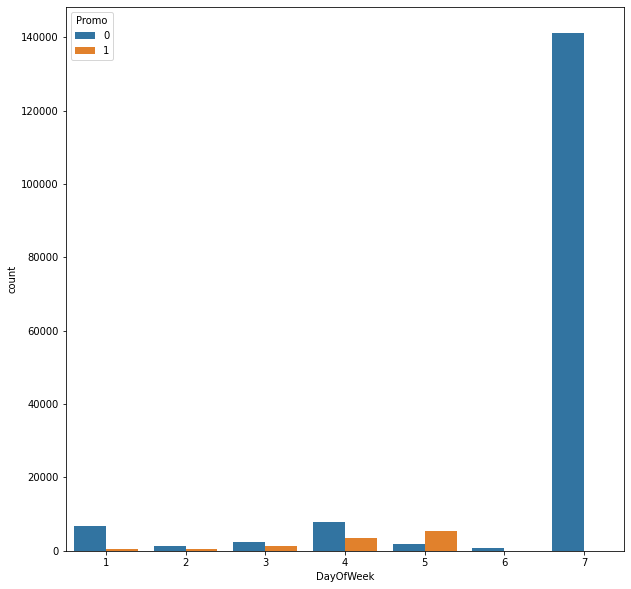

In [ ]:
ax = sns.countplot(x="DayOfWeek", hue = 'Promo', data=zero_sales);

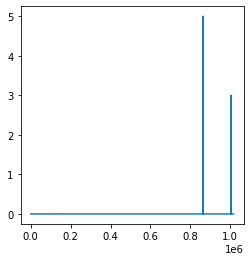

In [ ]:
# Is there any customers while Sales = 0 ? 
zero_sales.Customers.plot(figsize=(4,4));

In [ ]:
zero_sales[zero_sales['Customers']==3]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1003331,1100,2,2014-04-29,0,3,1,1,0,0,a,a,540.0,9.0,2013.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [ ]:
zero_sales[zero_sales['Customers']==5]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
864013,948,4,2013-04-25,0,5,1,1,0,0,b,b,1430.0,9.0,2013.0,0,0.0,0.0,0


#### **3. TIME SERIES**

In [ ]:
# For decomposition of the time series, I will need to copy the dataset
train_store2 = train_store.copy()

NameError: ignored

In [ ]:
# Set dates as index 
train_store2.set_index('Date', inplace =True)

In [ ]:
# Preparation for stationary test
y = train_store2['Sales'].resample('W').mean()

In [ ]:
y.head()

Date
2013-01-06    3906.314098
2013-01-13    6313.289174
2013-01-20    4404.582319
2013-01-27    5898.804484
2013-02-03    4928.382960
Freq: W-SUN, Name: Sales, dtype: float64

In [ ]:
y.shape

(135,)

In [ ]:
y.isnull().sum()

0

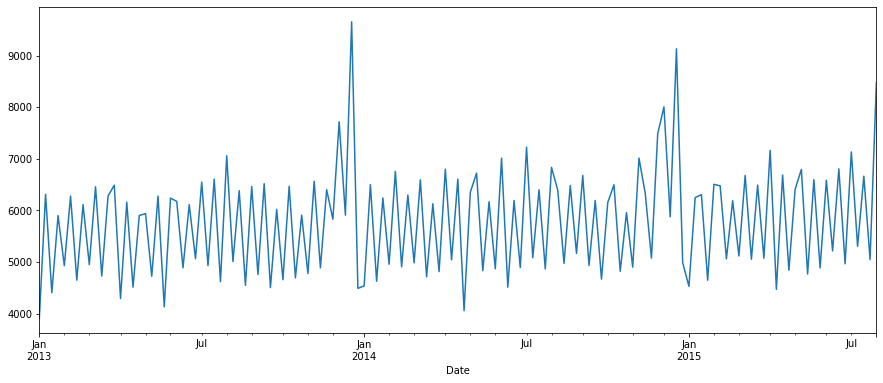

In [ ]:
y.plot(figsize=(15, 6))
plt.show()

In [ ]:
train_store2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 17 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Sales                      1017209 non-null  int64  
 3   Customers                  1017209 non-null  int64  
 4   Open                       1017209 non-null  int64  
 5   Promo                      1017209 non-null  int64  
 6   StateHoliday               1017209 non-null  object 
 7   SchoolHoliday              1017209 non-null  int64  
 8   StoreType                  1017209 non-null  object 
 9   Assortment                 1017209 non-null  object 
 10  CompetitionDistance        1017209 non-null  float64
 11  CompetitionOpenSinceMonth  1017209 non-null  float64
 12  CompetitionOpenSinceYear   1017209 non-null  float64
 1

In [ ]:
# Stationary Test (Dickey-Fuller Test)
def is_stationary(y):

    # "HO: Non-stationary"
    # "H1: Stationary"

    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        print(F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")


In [ ]:
# Let's see whether the data is stationary of not
is_stationary(y)

Result: Stationary (H0: non-stationary, p-value: 0.0)


In [ ]:
# Let's see the decomposition of dataset (components of time series)

def ts_decompose(y, model="additive", stationary=False):
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

    if stationary:
        is_stationary(y)

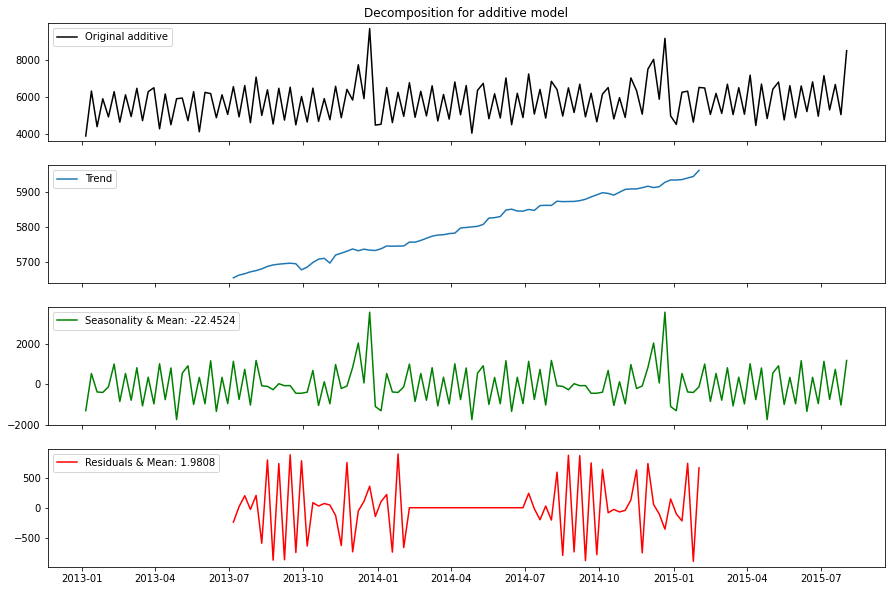

Result: Stationary (H0: non-stationary, p-value: 0.0)


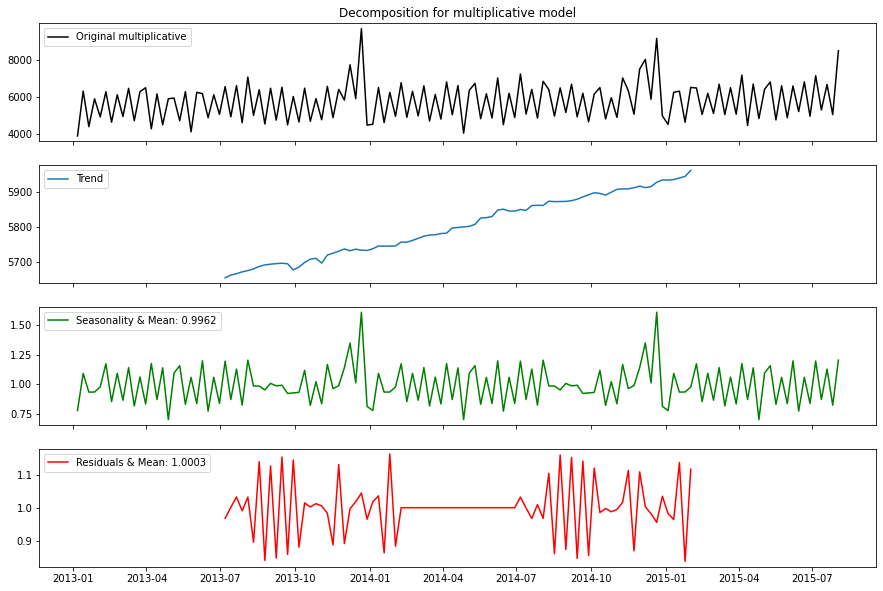

Result: Stationary (H0: non-stationary, p-value: 0.0)


In [ ]:
# Check both additive and multiplicative
for model in ["additive", "multiplicative"]:
    ts_decompose(y, model, stationary=True)

#### **HOLD-OUT**

In [ ]:
# Determine train set from 01-01-2013 to 21-06-2015 
train = y[:'2015-06-21']
len(train)   #129 weeks

129

In [ ]:
train

Date
2013-01-06    3906.314098
2013-01-13    6313.289174
2013-01-20    4404.582319
2013-01-27    5898.804484
2013-02-03    4928.382960
                 ...     
2015-05-24    6598.414222
2015-05-31    4884.740679
2015-06-07    6585.616656
2015-06-14    5214.198334
2015-06-21    6805.310058
Freq: W-SUN, Name: Sales, Length: 129, dtype: float64

In [ ]:
test = y['2015-06-22':]
len(test)  # 6 weeks

6

#### **Triple Exponential Smoothing (Holt-Winters) - Additive**


In [ ]:
tes_model = ExponentialSmoothing(train,
                                 trend="add",
                                 seasonal="add",
                                 seasonal_periods=52).fit(smoothing_level=0.5,
                                                          smoothing_slope=0.5,
                                                          smoothing_seasonal=0.5)

In [ ]:
y_pred = tes_model.forecast(6)

In [ ]:
tes_model

In [ ]:
y_pred

2015-06-28    5647.924650
2015-07-05    7830.525071
2015-07-12    5818.682406
2015-07-19    7440.253875
2015-07-26    5965.165807
2015-08-02    8239.759501
Freq: W-SUN, dtype: float64

In [ ]:
# Define a function to plot the prediction along with train and test 
def plot_sales(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    train["2013-01-01":].plot(legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae,2)}")
    test.plot(legend=True, label="TEST", figsize=(6, 4))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show()

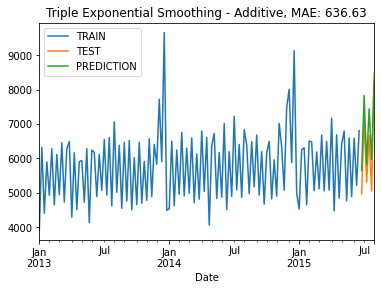

In [ ]:
plot_sales(train, test, y_pred, "Triple Exponential Smoothing - Additive")

In [ ]:
# Hyperparameter Optimisation (Additive)
def tes_optimizer(train, abg, step=6):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")

    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=52).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

In [ ]:
alphas = betas = gammas = np.arange(0.10, 1, 0.20)
abg = list(itertools.product(alphas, betas, gammas))

In [ ]:
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg)

[0.1, 0.1, 0.1, 288.36]
[0.1, 0.1, 0.3, 287.41]
[0.1, 0.1, 0.5, 287.7]
[0.1, 0.1, 0.7, 296.2]
[0.1, 0.1, 0.9, 341.34]
[0.1, 0.3, 0.1, 324.1]
[0.1, 0.3, 0.3, 293.75]
[0.1, 0.3, 0.5, 302.78]
[0.1, 0.3, 0.7, 325.51]
[0.1, 0.3, 0.9, 349.42]
[0.1, 0.5, 0.1, 333.01]
[0.1, 0.5, 0.3, 291.71]
[0.1, 0.5, 0.5, 272.33]
[0.1, 0.5, 0.7, 276.83]
[0.1, 0.5, 0.9, 323.67]
[0.1, 0.7, 0.1, 347.19]
[0.1, 0.7, 0.3, 307.01]
[0.1, 0.7, 0.5, 284.8]
[0.1, 0.7, 0.7, 264.08]
[0.1, 0.7, 0.9, 272.37]
[0.1, 0.9, 0.1, 365.7]
[0.1, 0.9, 0.3, 408.59]
[0.1, 0.9, 0.5, 458.12]
[0.1, 0.9, 0.7, 505.71]
[0.1, 0.9, 0.9, 565.46]
[0.3, 0.1, 0.1, 340.17]
[0.3, 0.1, 0.3, 361.55]
[0.3, 0.1, 0.5, 386.48]
[0.3, 0.1, 0.7, 425.05]
[0.3, 0.1, 0.9, 466.72]
[0.3, 0.3, 0.1, 371.51]
[0.3, 0.3, 0.3, 405.69]
[0.3, 0.3, 0.5, 446.4]
[0.3, 0.3, 0.7, 546.88]
[0.3, 0.3, 0.9, 627.47]
[0.3, 0.5, 0.1, 349.12]
[0.3, 0.5, 0.3, 337.62]
[0.3, 0.5, 0.5, 431.04]
[0.3, 0.5, 0.7, 524.62]
[0.3, 0.5, 0.9, 618.35]
[0.3, 0.7, 0.1, 368.15]
[0.3, 0.7, 0.3, 368.0]

In [ ]:
# Final TES Model (Additive)
final_tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=52).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

In [ ]:
y_pred = final_tes_model.forecast(6)

In [ ]:
y_pred

2015-06-28    5049.051983
2015-07-05    7255.350229
2015-07-12    5305.533850
2015-07-19    6813.210987
2015-07-26    5267.585823
2015-08-02    7463.238598
Freq: W-SUN, dtype: float64

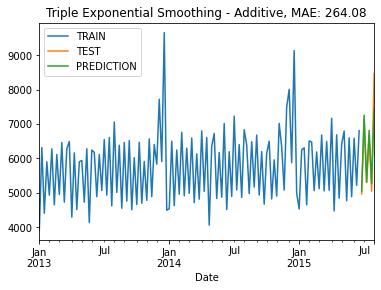

In [ ]:
plot_sales(train, test, y_pred, "Triple Exponential Smoothing - Additive")

#### **TES for Multiplicative Model**

In [ ]:
tes_model_mul = ExponentialSmoothing(train,
                                 trend="mul",
                                 seasonal="mul",
                                 seasonal_periods=52).fit(smoothing_level=0.5,
                                                          smoothing_slope=0.5,
                                                          smoothing_seasonal=0.5)

In [ ]:

y_pred_mul = tes_model_mul.forecast(6)

In [ ]:
tes_model_mul

In [ ]:
y_pred_mul

2015-06-28     5853.907086
2015-07-05     8801.688051
2015-07-12     6583.958870
2015-07-19     9161.687886
2015-07-26     7428.895354
2015-08-02    11702.293509
Freq: W-SUN, dtype: float64

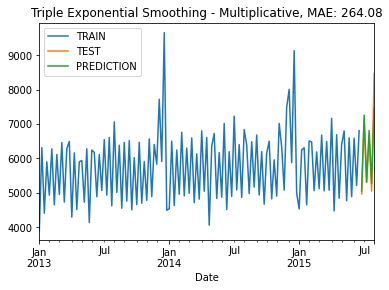

In [ ]:
plot_sales(train, test, y_pred, "Triple Exponential Smoothing - Multiplicative")

In [ ]:
# Hyperparameter Optimisation (Multiplicative)
def tes_optimizer(train, abg, step=6):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")

    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=52).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

In [ ]:
alphas = betas = gammas = np.arange(0.10, 1, 0.20)
abg = list(itertools.product(alphas, betas, gammas))

In [ ]:
best_alpha_mul, best_beta_mul, best_gamma_mul, best_mae_mul = tes_optimizer(train, abg)

[0.1, 0.1, 0.1, 302.24]
[0.1, 0.1, 0.3, 299.61]
[0.1, 0.1, 0.5, 297.77]
[0.1, 0.1, 0.7, 293.98]
[0.1, 0.1, 0.9, 331.23]
[0.1, 0.3, 0.1, 384.08]
[0.1, 0.3, 0.3, 335.77]
[0.1, 0.3, 0.5, 328.11]
[0.1, 0.3, 0.7, 359.66]
[0.1, 0.3, 0.9, 432.66]
[0.1, 0.5, 0.1, 412.75]
[0.1, 0.5, 0.3, 366.48]
[0.1, 0.5, 0.5, 355.53]
[0.1, 0.5, 0.7, 378.34]
[0.1, 0.5, 0.9, 436.43]
[0.1, 0.7, 0.1, 409.69]
[0.1, 0.7, 0.3, 419.0]
[0.1, 0.7, 0.5, 467.82]
[0.1, 0.7, 0.7, 617.65]
[0.1, 0.7, 0.9, 784.83]
[0.1, 0.9, 0.1, 515.73]
[0.1, 0.9, 0.3, 836.99]
[0.1, 0.9, 0.5, 1264.12]
[0.1, 0.9, 0.7, 1689.35]
[0.1, 0.9, 0.9, 2116.66]
[0.3, 0.1, 0.1, 328.25]
[0.3, 0.1, 0.3, 373.35]
[0.3, 0.1, 0.5, 443.29]
[0.3, 0.1, 0.7, 539.66]
[0.3, 0.1, 0.9, 646.5]
[0.3, 0.3, 0.1, 376.94]
[0.3, 0.3, 0.3, 447.91]
[0.3, 0.3, 0.5, 597.17]
[0.3, 0.3, 0.7, 748.38]
[0.3, 0.3, 0.9, 914.99]
[0.3, 0.5, 0.1, 458.39]
[0.3, 0.5, 0.3, 409.55]
[0.3, 0.5, 0.5, 497.21]
[0.3, 0.5, 0.7, 619.99]
[0.3, 0.5, 0.9, 720.57]
[0.3, 0.7, 0.1, 581.65]
[0.3, 0.7, 0.3,

In [ ]:
# Final TES Model (Multiplicative)
final_tes_model_mul = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=52).\
            fit(smoothing_level=best_alpha_mul, smoothing_slope=best_beta_mul, smoothing_seasonal=best_gamma_mul)

In [ ]:
y_pred_mul = final_tes_model_mul.forecast(6)

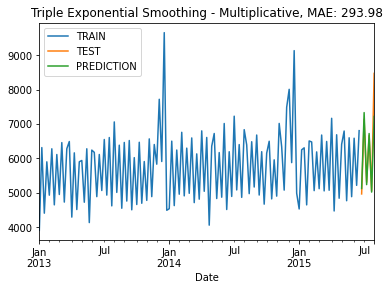

In [ ]:
plot_sales(train, test, y_pred_mul, "Triple Exponential Smoothing - Multiplicative")

#### **ADDITIVE Mİ? MULTIPLICATIVE Mİ?**

#### **SARIMA(p, d, q): (Seasonal Autoregressive Integrated Moving-Average)**

In [ ]:
model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(0, 0, 0, 52))
sarima_model = model.fit(disp=0)

In [ ]:
y_pred_test = sarima_model.get_forecast(steps=6)
y_pred = y_pred_test.predicted_mean
y_pred = pd.Series(y_pred, index=test.index)

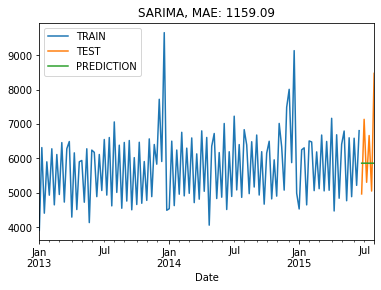

In [ ]:
plot_sales(train, test, y_pred, "SARIMA")

In [ ]:
# Hyperparameter Optimisation 
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [ ]:
# SARIMA Optimizer
def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), float("inf"), None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
                print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, aic))
            except:
                continue
    print('SARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order

In [ ]:
best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 52)12 - AIC:2606.176765107501
SARIMA(0, 0, 0)x(0, 1, 0, 52)12 - AIC:1280.6943290668014
SARIMA(0, 0, 0)x(1, 0, 0, 52)12 - AIC:2332.4391858966733
SARIMA(0, 0, 0)x(1, 1, 0, 52)12 - AIC:1282.2168520121968
SARIMA(0, 0, 1)x(0, 0, 0, 52)12 - AIC:2511.9109395893065
SARIMA(0, 0, 1)x(0, 1, 0, 52)12 - AIC:1256.9030825285665
SARIMA(0, 0, 1)x(1, 0, 0, 52)12 - AIC:2334.341713804909
SARIMA(0, 0, 1)x(1, 1, 0, 52)12 - AIC:1252.3428150548925
SARIMA(0, 1, 0)x(0, 0, 0, 52)12 - AIC:2277.5172218353346
SARIMA(0, 1, 0)x(0, 1, 0, 52)12 - AIC:1358.023221087819
SARIMA(0, 1, 0)x(1, 0, 0, 52)12 - AIC:2261.466777239136
SARIMA(0, 1, 0)x(1, 1, 0, 52)12 - AIC:1349.132893328795
SARIMA(0, 1, 1)x(0, 0, 0, 52)12 - AIC:2156.9825253719105
SARIMA(0, 1, 1)x(0, 1, 0, 52)12 - AIC:1275.6640780174198
SARIMA(0, 1, 1)x(1, 0, 0, 52)12 - AIC:2131.8573108113924
SARIMA(0, 1, 1)x(1, 1, 0, 52)12 - AIC:1267.4762795839108
SARIMA(1, 0, 0)x(0, 0, 0, 52)12 - AIC:2296.6950848072865
SARIMA(1, 0, 0)x(0, 1, 0, 52)12 - AI

In [ ]:
# Final Model for SARIMA
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

In [ ]:
y_pred_test = sarima_final_model.get_forecast(steps=6)

In [ ]:
# MAE
y_pred = y_pred_test.predicted_mean
y_pred = pd.Series(y_pred, index=test.index)

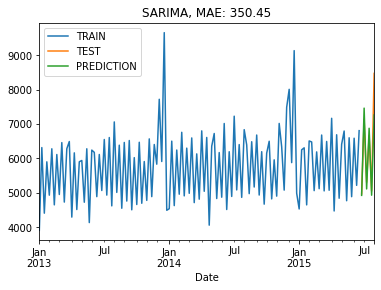

In [ ]:
plot_sales(train, test, y_pred, "SARIMA")

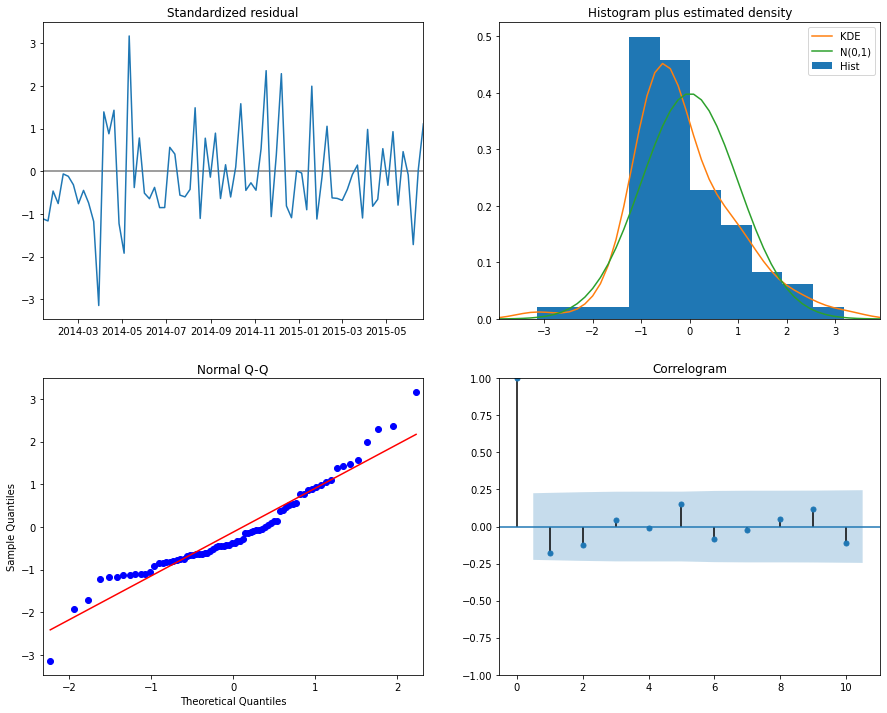

In [ ]:
# Statistical Outputs of the Model 
sarima_final_model.plot_diagnostics(figsize=(15, 12))
plt.show()

#### **Optimization According to MAE**

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [ ]:
def sarima_optimizer_mae(train, pdq, seasonal_pdq):
    best_mae, best_order, best_seasonal_order = float("inf"), float("inf"), None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                sarima_model = model.fit(disp=0)
                y_pred_test = sarima_model.get_forecast(steps=6)
                y_pred = y_pred_test.predicted_mean
                mae = mean_absolute_error(test, y_pred)

                # mae = fit_model_sarima(train, val, param, param_seasonal)

                if mae < best_mae:
                    best_mae, best_order, best_seasonal_order = mae, param, param_seasonal
                print('SARIMA{}x{}12 - MAE:{}'.format(param, param_seasonal, mae))
            except:
                continue
    print('SARIMA{}x{}12 - MAE:{}'.format(best_order, best_seasonal_order, best_mae))
    return best_order, best_seasonal_order

In [ ]:
best_order, best_seasonal_order = sarima_optimizer_mae(train, pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 52)12 - MAE:6264.474849455477
SARIMA(0, 0, 0)x(0, 1, 0, 52)12 - MAE:411.67439096449
SARIMA(0, 0, 0)x(1, 0, 0, 52)12 - MAE:461.870261963504
SARIMA(0, 0, 0)x(1, 1, 0, 52)12 - MAE:416.3945202551475
SARIMA(0, 0, 1)x(0, 0, 0, 52)12 - MAE:5645.214644623091
SARIMA(0, 0, 1)x(0, 1, 0, 52)12 - MAE:472.3276770956565
SARIMA(0, 0, 1)x(1, 0, 0, 52)12 - MAE:458.66923823214665
SARIMA(0, 0, 1)x(1, 1, 0, 52)12 - MAE:515.292657917818
SARIMA(0, 1, 0)x(0, 0, 0, 52)12 - MAE:1206.3437796284431
SARIMA(0, 1, 0)x(0, 1, 0, 52)12 - MAE:572.970694239163
SARIMA(0, 1, 0)x(1, 0, 0, 52)12 - MAE:852.1246909358691
SARIMA(0, 1, 0)x(1, 1, 0, 52)12 - MAE:532.7888120957117
SARIMA(0, 1, 1)x(0, 0, 0, 52)12 - MAE:1159.0652829382873
SARIMA(0, 1, 1)x(0, 1, 0, 52)12 - MAE:330.03718343016027
SARIMA(0, 1, 1)x(1, 0, 0, 52)12 - MAE:643.8721443312032
SARIMA(0, 1, 1)x(1, 1, 0, 52)12 - MAE:318.7790483569511
SARIMA(1, 0, 0)x(0, 0, 0, 52)12 - MAE:1294.1801795963454
SARIMA(1, 0, 0)x(0, 1, 0, 52)12 - MAE:551.969904

In [ ]:
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

In [ ]:
y_pred_test = sarima_final_model.get_forecast(steps=6)
y_pred = y_pred_test.predicted_mean
y_pred = pd.Series(y_pred, index=test.index)

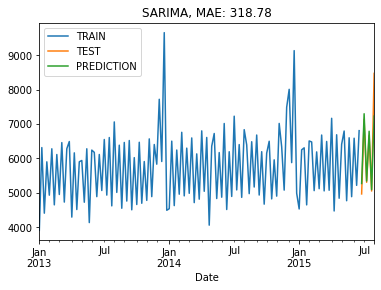

In [ ]:
plot_sales(train, test, y_pred, "SARIMA")

#### **4. FEATURE ENGINEERING**

In [ ]:
train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [ ]:
train_store3 = train_store.copy()

In [ ]:
train_store3.columns= train_store3.columns.str.lower()

In [ ]:
# Create date features
df = create_date_features(train_store3)

In [ ]:
# Check the version with date features
check_df(df)

##################### Shape #####################
(1017209, 26)
##################### Types #####################
store                                 int64
dayofweek                             int64
date                         datetime64[ns]
sales                                 int64
customers                             int64
open                                  int64
promo                                 int64
stateholiday                         object
schoolholiday                         int64
storetype                            object
assortment                           object
competitiondistance                 float64
competitionopensincemonth           float64
competitionopensinceyear            float64
promo2                                int64
promo2sinceweek                     float64
promo2sinceyear                     float64
promointerval                        object
month                                 int64
day_of_month                          int64
day_of

In [ ]:
df.groupby(["storetype", "year"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                                   
                       sum          mean  median          std
storetype year                                               
a         2013  1246063027   5670.908378  5525.0  3951.051513
          2014  1181741424   5785.079961  5648.0  4002.073419
          2015   737530408   5778.931925  5732.0  3923.331789
b         2013    57966559   9341.911201  8414.0  5504.456909
          2014    62615162  10399.462216  9294.0  5093.839702
          2015    38649674  10724.104883  9767.0  5045.303541
c         2013   304755298   5641.527175  5617.5  3780.019550
          2014   296773142   5768.858215  5834.0  3712.710525
          2015   181692986   5790.826938  5918.0  3631.641116
d         2013   694091200   5464.424500  5625.0  3394.228949
          2014   639675168   5705.476185  5890.0  3501.151818
          2015   431626575   5850.501179  6079.0  3550.033922

In [ ]:
df.groupby("storetype").agg({"sales": "sum", "customers": "sum"}).sort_values('sales', ascending=False)

,sales,customers
storetype,,
a,3165334859,363541434
d,1765392943,156904995
c,783221426,92129705
b,159231395,31465621


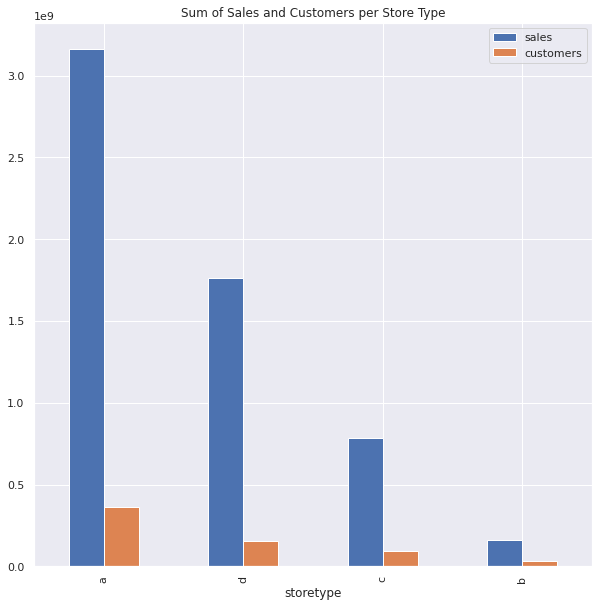

In [ ]:
# Sum of sales per store type
df.groupby("storetype").agg({"sales": "sum", "customers": "sum"}).sort_values('sales', ascending=False).plot(kind = 'bar',
                                                                                                    title='Sum of Sales and Customers per Store Type');

#### Now it is clear that Store Type A and Store Type D has more sales and customers (as sum). 

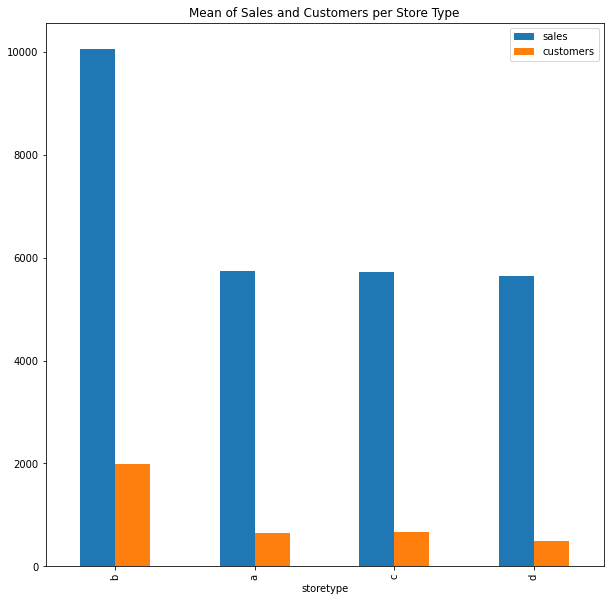

In [ ]:
# Mean of sales and customers per store type
df.groupby("storetype").agg({"sales": "mean", "customers": "mean"}).sort_values('sales', ascending=False).plot(kind = 'bar',
                                                                                                    title='Mean of Sales and Customers per Store Type');

#### When we check the mean of sales and customers Store Type B is the lead.

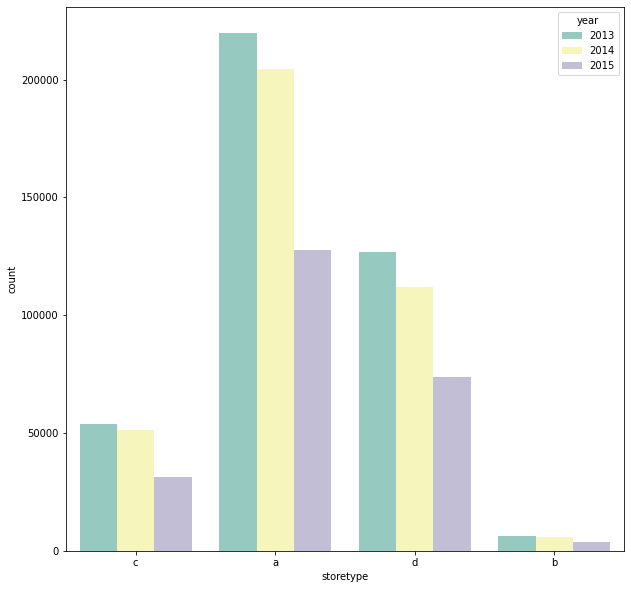

In [ ]:
ax = sns.countplot(x="storetype", hue = 'year', data=df, palette="Set3");

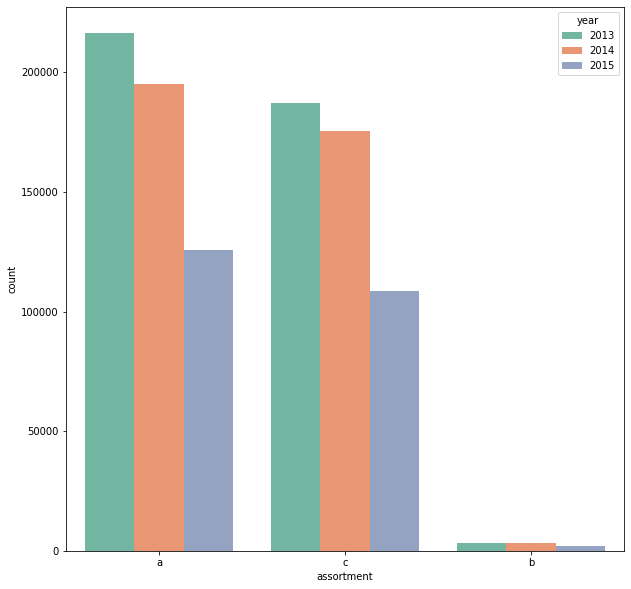

In [ ]:
ax = sns.countplot(x="assortment", hue = 'year', data=df, palette="Set2");

#### **4.1. Create Lag Features**

In [ ]:
df3 =pd.concat([train_df,test_df])

In [ ]:
df3.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Id
0,1,5,2015-07-31,5263.0,555.0,1.0,1,0,1,NaN
1,2,5,2015-07-31,6064.0,625.0,1.0,1,0,1,NaN
2,3,5,2015-07-31,8314.0,821.0,1.0,1,0,1,NaN
3,4,5,2015-07-31,13995.0,1498.0,1.0,1,0,1,NaN
4,5,5,2015-07-31,4822.0,559.0,1.0,1,0,1,NaN


In [ ]:
df3.columns = df3.columns.str.lower()

In [ ]:
create_date_features(df3)

,store,dayofweek,date,sales,customers,open,promo,stateholiday,schoolholiday,id,month,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end
0,1,5,2015-07-31,5263.0,555.0,1.0,1,0,1,NaN,7,31,212,31,2015,1,0,1
1,2,5,2015-07-31,6064.0,625.0,1.0,1,0,1,NaN,7,31,212,31,2015,1,0,1
2,3,5,2015-07-31,8314.0,821.0,1.0,1,0,1,NaN,7,31,212,31,2015,1,0,1
3,4,5,2015-07-31,13995.0,1498.0,1.0,1,0,1,NaN,7,31,212,31,2015,1,0,1
4,5,5,2015-07-31,4822.0,559.0,1.0,1,0,1,NaN,7,31,212,31,2015,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,1111,6,2015-08-01,NaN,NaN,1.0,0,0,0,41084.0,8,1,213,31,2015,1,1,0
41084,1112,6,2015-08-01,NaN,NaN,1.0,0,0,0,41085.0,8,1,213,31,2015,1,1,0
41085,1113,6,2015-08-01,NaN,NaN,1.0,0,0,0,41086.0,8,1,213,31,2015,1,1,0
41086,1114,6,2015-08-01,NaN,NaN,1.0,0,0,0,41087.0,8,1,213,31,2015,1,1,0


In [ ]:
# Create lag features
# First, we need to sort the dataframe
df4 = df3.sort_values(by=['store', 'date'], axis=0)

In [ ]:
df4.head()

,store,dayofweek,date,sales,customers,open,promo,stateholiday,schoolholiday,id,month,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end
1016095,1,2,2013-01-01,0.0,0.0,0.0,0,a,1,NaN,1,1,1,1,2013,0,1,0
1014980,1,3,2013-01-02,5530.0,668.0,1.0,0,0,1,NaN,1,2,2,1,2013,0,0,0
1013865,1,4,2013-01-03,4327.0,578.0,1.0,0,0,1,NaN,1,3,3,1,2013,0,0,0
1012750,1,5,2013-01-04,4486.0,619.0,1.0,0,0,1,NaN,1,4,4,1,2013,1,0,0
1011635,1,6,2013-01-05,4997.0,635.0,1.0,0,0,1,NaN,1,5,5,1,2013,1,0,0


In [ ]:
# Create lag features 
# We will forecast 6 weeks. 
# 6 x 7 = 42 days. 
# Lags are determined accordingly. 
df_ = lag_features(df4, [22, 29, 36, 43, 50, 57, 64, 71, 78, 85, 125, 169, 182, 253, 364, 546])

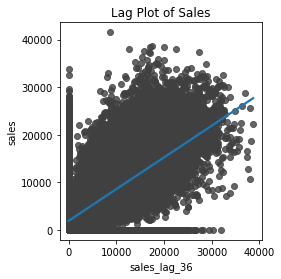

In [ ]:
# Check 
fig, ax = plt.subplots()
ax = sns.regplot(x='sales_lag_36', y='sales', data=df_, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Sales');

In [ ]:
# Create rolling mean features
df_ = roll_mean_features(df_, [29, 36, 43, 85, 169, 364, 546])

In [ ]:
df_.tail(10)

,store,dayofweek,date,sales,customers,open,promo,stateholiday,schoolholiday,id,month,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_22,sales_lag_29,sales_lag_36,sales_lag_43,sales_lag_50,sales_lag_57,sales_lag_64,sales_lag_71,sales_lag_78,sales_lag_85,sales_lag_125,sales_lag_169,sales_lag_182,sales_lag_253,sales_lag_364,sales_lag_546,sales_roll_mean_29,sales_roll_mean_36,sales_roll_mean_43,sales_roll_mean_85,sales_roll_mean_169,sales_roll_mean_364,sales_roll_mean_546
8559,1115,2,2015-09-08,NaN,NaN,1.0,0,0,0,8560.0,9,8,251,37,2015,0,0,0,NaN,5074.132438,5686.518121,6675.715212,7822.562003,5918.597558,6156.700645,7608.573081,4.827996,4037.529813,-1.572399,6195.194733,7587.820366,6919.876231,4739.887694,4475.183297,NaN,4545.534325,4643.872010,4673.234502,4598.867811,4434.639404,4214.161046
7703,1115,3,2015-09-09,NaN,NaN,1.0,0,0,0,7704.0,9,9,252,37,2015,0,0,0,NaN,5345.317785,5844.916803,0.632285,-1.283971,5118.210051,6363.229462,8136.625294,8509.176925,4939.703907,6632.333999,5858.662417,3.177076,1.361414,6079.934632,5412.336847,NaN,4520.502563,4645.748934,4668.348911,4600.615835,4436.891833,4217.984092
6847,1115,4,2015-09-10,NaN,NaN,1.0,0,0,0,6848.0,9,10,253,37,2015,0,0,0,NaN,6150.942730,7163.973544,6545.726159,5096.128307,4676.122098,8036.919258,-0.458157,-1.816642,5252.457534,1.005500,5782.997024,5050.244639,6070.218674,-1.895891,-0.861374,NaN,4508.369331,4661.644478,4664.085611,4603.185465,4441.298589,4220.361972
5991,1115,5,2015-09-11,NaN,NaN,1.0,0,0,0,5992.0,9,11,254,37,2015,1,0,0,NaN,5814.548346,-1.928570,-2.019432,5157.313128,5217.976139,9226.342221,8004.952971,5024.676286,5244.037832,5099.471495,5883.841883,4629.225657,-1.400285,6244.135105,5004.987481,NaN,4531.218271,4654.431172,4666.162081,4603.493118,4444.153117,4224.315600
5135,1115,6,2015-09-12,NaN,NaN,1.0,0,0,0,5136.0,9,12,255,37,2015,1,0,0,NaN,6899.582064,7263.560604,6501.012054,5459.338238,5316.617556,-3.929658,-3.774840,5571.797276,7618.697154,5969.590266,5341.164641,5042.247321,5084.534061,-1.403614,0.060281,NaN,NaN,4656.842604,4672.700141,4601.362472,4445.701516,4223.617180
4279,1115,7,2015-09-13,NaN,NaN,0.0,0,0,0,4280.0,9,13,256,37,2015,1,0,0,NaN,-0.708414,-4.439633,5138.666635,5013.231536,7735.828604,6595.212391,-0.074734,7293.512506,-2.167265,5274.413465,7882.665457,4583.541149,4602.691053,4042.731371,3438.292486,NaN,NaN,4618.820132,4676.870462,4602.330162,4448.392275,4226.976611
3423,1115,1,2015-09-14,NaN,NaN,1.0,1,0,0,3424.0,9,14,257,38,2015,0,0,0,6590.564040,8611.950305,11432.233561,7643.450676,9819.717390,6962.139701,9053.696018,7784.251462,7008.842971,8087.472358,8827.034584,6576.082548,7502.759741,6382.831624,6126.341847,NaN,8166.849949,8207.653545,8172.425114,7911.660290,7823.302454,7223.879568,6833.455378
2567,1115,2,2015-09-15,NaN,NaN,1.0,1,0,0,2568.0,9,15,258,38,2015,0,0,0,7873.186550,7700.814975,10852.660386,6245.402897,7003.276741,8308.769122,10547.288806,9217.031090,6820.244307,7220.784505,7608.124032,6455.207299,7036.658669,5962.964321,4811.168625,NaN,8179.403659,8193.062482,8189.653103,7919.114875,7826.696958,7228.168911,6835.468088
1711,1115,3,2015-09-16,NaN,NaN,1.0,1,0,0,1712.0,9,16,259,38,2015,0,0,0,10711.179699,6859.828138,7862.793145,8448.205999,8166.868280,10208.688719,11033.212710,7377.551695,7570.593101,7067.907139,7440.824698,6495.030386,9217.009066,6804.023233,5505.951134,NaN,8209.686408,8189.316373,8209.421770,7926.735877,7828.001286,7232.829310,6839.844304
855,1115,4,2015-09-17,NaN,NaN,1.0,1,0,0,856.0,9,17,260,38,2015,0,0,0,8092.788739,7413.896202,8421.858995,8409.198667,7345.689552,7288.887546,2.328993,7660.500669,9715.221063,6170.847408,6708.680064,6707.051508,8226.010796,10080.114097,5652.053549,NaN,8238.808410,8192.382802,8203.972424,7937.890846,7834.845726,7239.562500,6846.677407


In [ ]:
# Exponentially Weighted Mean Features
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [29, 36, 43, 50, 57, 64, 85, 128]

In [ ]:
df_ = ewm_features(df_, alphas, lags)

#### **4.2. One Hot Encoding**

In [ ]:
check_df(df_)

##################### Shape #####################
(1058297, 81)
##################### Types #####################
store                                  int64
dayofweek                              int64
date                          datetime64[ns]
sales                                float64
customers                            float64
                                   ...      
sales_ewm_alpha_05_lag_50            float64
sales_ewm_alpha_05_lag_57            float64
sales_ewm_alpha_05_lag_64            float64
sales_ewm_alpha_05_lag_85            float64
sales_ewm_alpha_05_lag_128           float64
Length: 81, dtype: object
##################### Head #####################
         store  dayofweek       date   sales  customers  open  promo stateholiday  schoolholiday  id  month  day_of_month  day_of_year  week_of_year  year  is_wknd  is_month_start  is_month_end  sales_lag_22  sales_lag_29  sales_lag_36  sales_lag_43  sales_lag_50  sales_lag_57  sales_lag_64  sales_lag_71  sales_lag

In [ ]:
store_df.columns= store_df.columns.str.lower()

In [ ]:
dff= pd.merge(df_, store_df, how = 'inner', on = 'store')

In [ ]:
dff.columns

Index(['store', 'dayofweek', 'date', 'sales', 'customers', 'open', 'promo', 'stateholiday', 'schoolholiday', 'id', 'month', 'day_of_month', 'day_of_year', 'week_of_year', 'year', 'is_wknd', 'is_month_start', 'is_month_end', 'sales_lag_22', 'sales_lag_29', 'sales_lag_36', 'sales_lag_43', 'sales_lag_50', 'sales_lag_57', 'sales_lag_64', 'sales_lag_71', 'sales_lag_78', 'sales_lag_85', 'sales_lag_125', 'sales_lag_169', 'sales_lag_182', 'sales_lag_253', 'sales_lag_364', 'sales_lag_546',
       'sales_roll_mean_29', 'sales_roll_mean_36', 'sales_roll_mean_43', 'sales_roll_mean_85', 'sales_roll_mean_169', 'sales_roll_mean_364', 'sales_roll_mean_546', 'sales_ewm_alpha_095_lag_29', 'sales_ewm_alpha_095_lag_36', 'sales_ewm_alpha_095_lag_43', 'sales_ewm_alpha_095_lag_50', 'sales_ewm_alpha_095_lag_57', 'sales_ewm_alpha_095_lag_64', 'sales_ewm_alpha_095_lag_85', 'sales_ewm_alpha_095_lag_128', 'sales_ewm_alpha_09_lag_29', 'sales_ewm_alpha_09_lag_36', 'sales_ewm_alpha_09_lag_43',
       'sales_ewm_alph

In [ ]:
check_df(dff)

##################### Shape #####################
(1058297, 90)
##################### Types #####################
store                                int64
dayofweek                            int64
date                        datetime64[ns]
sales                              float64
customers                          float64
                                 ...      
competitionopensinceyear           float64
promo2                               int64
promo2sinceweek                    float64
promo2sinceyear                    float64
promointerval                       object
Length: 90, dtype: object
##################### Head #####################
   store  dayofweek       date   sales  customers  open  promo stateholiday  schoolholiday  id  month  day_of_month  day_of_year  week_of_year  year  is_wknd  is_month_start  is_month_end  sales_lag_22  sales_lag_29  sales_lag_36  sales_lag_43  sales_lag_50  sales_lag_57  sales_lag_64  sales_lag_71  sales_lag_78  sales_lag_85  sales_lag

In [ ]:
# Categorical variables
[col for col in dff.columns if dff[col].dtypes == 'O']

['stateholiday', 'storetype', 'assortment', 'promointerval']

In [ ]:
# Numerical but categorical variables
[col for col in dff.columns if dff[col].nunique() < 10 and dff[col].dtypes != "O"]

['dayofweek',
 'open',
 'promo',
 'schoolholiday',
 'year',
 'is_wknd',
 'is_month_start',
 'is_month_end',
 'promo2',
 'promo2sinceyear']

#### Before implementing one hot encoding, we need to decide which variables will be one hot encoded. We can select all categorical variables: 
* stateholiday 
* storetype
* assortment
* promointerval

#### Considering "numerical but categorical variables", it makes sense to choose: 
* dayofweek
* year
* promo2sinceyear

Because, others are binary variables (They are already 0 and 1, so no need to implement one hot encoding). 

In [ ]:
dff_ = pd.get_dummies(dff, columns=['stateholiday','storetype', 'assortment', 'promointerval', 'dayofweek',
                                   'year','promo2sinceyear'],drop_first=True)

In [ ]:
#Converting sales to log(1+sales)
dff_['sales'] = np.log1p(dff_["sales"].values)

#### **4.3. Time Based Validation Sets**

In [ ]:
dff_['date'].min(), df3['date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

#### $ Determine$ $train$ $and$ $validation$ $sets $:
#### Considering that the test dataset's date is between 01.08.2015 - 17.09.2015, we will determine our train and validation set as below:    
* train: 01.01.2013 - 31.07.2014
* val: 01.08.2014 - 17.09.2014 

In [ ]:
train_ = dff_.loc[(dff_["date"] < "2014-08-01"), :]

In [ ]:
val = dff_.loc[(dff_["date"] >= "2014-08-01") & (dff_["date"] < "2014-09-18"), :]

In [ ]:
val.columns

Index(['store', 'date', 'sales', 'customers', 'open', 'promo', 'schoolholiday', 'id', 'month', 'day_of_month',
       ...
       'dayofweek_7', 'year_2014', 'year_2015', 'promo2sinceyear_2009.0', 'promo2sinceyear_2010.0', 'promo2sinceyear_2011.0', 'promo2sinceyear_2012.0', 'promo2sinceyear_2013.0', 'promo2sinceyear_2014.0', 'promo2sinceyear_2015.0'], dtype='object', length=110)

#####  **CUSTOMERS ÇIKARILMALI**

In [ ]:
#######################################################################
cols = [col for col in train_.columns if col not in ['date', "sales", "customers","year","id"]]

In [ ]:
Y_train = train_['sales']
X_train = train_[cols]

In [ ]:
Y_val = val['sales']


In [ ]:
X_val = val[cols]

In [ ]:
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((637774,), (637774, 106), (44880,), (44880, 106))

In [ ]:
pd.set_option('display.max_rows', None)
X_train.isnull().sum()

store                                  0
open                                   0
promo                                  0
schoolholiday                          0
month                                  0
day_of_month                           0
day_of_year                            0
week_of_year                           0
is_wknd                                0
is_month_start                         0
is_month_end                           0
sales_lag_22                       49060
sales_lag_29                       64670
sales_lag_36                       80280
sales_lag_43                       95890
sales_lag_50                      111500
sales_lag_57                      127110
sales_lag_64                      142720
sales_lag_71                      158330
sales_lag_78                      173940
sales_lag_85                      189550
sales_lag_125                     278750
sales_lag_169                     376870
sales_lag_182                     405860
sales_lag_253   

In [ ]:
X_val.isnull().sum().sum()

81346

#### **5. MACHINE LEARNING**

#### **5.1. LightGBM Model**

In [ ]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 10,
              'verbose': 0,
              'num_boost_round': 10000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [ ]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

In [ ]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_mae,
                  verbose_eval=100)

Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.386737	training's MAE: 1420.2	valid_1's l1: 0.370663	valid_1's MAE: 1476.29
[200]	training's l1: 0.153686	training's MAE: 859.972	valid_1's l1: 0.144558	valid_1's MAE: 811.91
[300]	training's l1: 0.125567	training's MAE: 781.393	valid_1's l1: 0.118105	valid_1's MAE: 718.144
[400]	training's l1: 0.118113	training's MAE: 731.007	valid_1's l1: 0.113738	valid_1's MAE: 673.259
[500]	training's l1: 0.113179	training's MAE: 697.824	valid_1's l1: 0.109753	valid_1's MAE: 647.175
[600]	training's l1: 0.10968	training's MAE: 675.772	valid_1's l1: 0.106903	valid_1's MAE: 630.666
[700]	training's l1: 0.107205	training's MAE: 659.643	valid_1's l1: 0.104972	valid_1's MAE: 618.707
[800]	training's l1: 0.1052	training's MAE: 647.58	valid_1's l1: 0.103529	valid_1's MAE: 611.046
[900]	training's l1: 0.10358	training's MAE: 637.679	valid_1's l1: 0.102262	valid_1's MAE: 604.404
[1000]	training's l1: 0.102088	training's MA

In [ ]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

In [ ]:
y_pred_val.shape

(44880,)

In [ ]:
mae(np.expm1(y_pred_val), np.expm1(Y_val))

578.9792012769799

In [ ]:
y_pred_val_ = pd.Series(y_pred_val,index=val.date.tolist())



In [ ]:
dff_.head()

,store,date,sales,customers,open,promo,schoolholiday,id,month,day_of_month,day_of_year,week_of_year,is_wknd,is_month_start,is_month_end,sales_lag_22,sales_lag_29,sales_lag_36,sales_lag_43,sales_lag_50,sales_lag_57,sales_lag_64,sales_lag_71,sales_lag_78,sales_lag_85,sales_lag_125,sales_lag_169,sales_lag_182,sales_lag_253,sales_lag_364,sales_lag_546,sales_roll_mean_29,sales_roll_mean_36,sales_roll_mean_43,sales_roll_mean_85,sales_roll_mean_169,sales_roll_mean_364,sales_roll_mean_546,sales_ewm_alpha_095_lag_29,sales_ewm_alpha_095_lag_36,sales_ewm_alpha_095_lag_43,sales_ewm_alpha_095_lag_50,sales_ewm_alpha_095_lag_57,sales_ewm_alpha_095_lag_64,sales_ewm_alpha_095_lag_85,sales_ewm_alpha_095_lag_128,sales_ewm_alpha_09_lag_29,sales_ewm_alpha_09_lag_36,sales_ewm_alpha_09_lag_43,sales_ewm_alpha_09_lag_50,sales_ewm_alpha_09_lag_57,sales_ewm_alpha_09_lag_64,sales_ewm_alpha_09_lag_85,sales_ewm_alpha_09_lag_128,sales_ewm_alpha_08_lag_29,sales_ewm_alpha_08_lag_36,sales_ewm_alpha_08_lag_43,sales_ewm_alpha_08_lag_50,sales_ewm_alpha_08_lag_57,sales_ewm_alpha_08_lag_64,sales_ewm_alpha_08_lag_85,sales_ewm_alpha_08_lag_128,sales_ewm_alpha_07_lag_29,sales_ewm_alpha_07_lag_36,sales_ewm_alpha_07_lag_43,sales_ewm_alpha_07_lag_50,sales_ewm_alpha_07_lag_57,sales_ewm_alpha_07_lag_64,sales_ewm_alpha_07_lag_85,sales_ewm_alpha_07_lag_128,sales_ewm_alpha_05_lag_29,sales_ewm_alpha_05_lag_36,sales_ewm_alpha_05_lag_43,sales_ewm_alpha_05_lag_50,sales_ewm_alpha_05_lag_57,sales_ewm_alpha_05_lag_64,sales_ewm_alpha_05_lag_85,sales_ewm_alpha_05_lag_128,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,stateholiday_a,stateholiday_b,stateholiday_c,storetype_b,storetype_c,storetype_d,assortment_b,assortment_c,"promointerval_Feb,May,Aug,Nov","promointerval_Jan,Apr,Jul,Oct","promointerval_Mar,Jun,Sept,Dec",dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,dayofweek_7,year_2014,year_2015,promo2sinceyear_2009.0,promo2sinceyear_2010.0,promo2sinceyear_2011.0,promo2sinceyear_2012.0,promo2sinceyear_2013.0,promo2sinceyear_2014.0,promo2sinceyear_2015.0
0,1,2013-01-01,0.000000,0.0,0.0,0,1,NaN,1,1,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1270.0,9.0,2008.0,0,0.0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2013-01-02,8.618124,668.0,1.0,0,1,NaN,1,2,2,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1270.0,9.0,2008.0,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,2013-01-03,8.372861,578.0,1.0,0,1,NaN,1,3,3,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1270.0,9.0,2008.0,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1,2013-01-04,8.408940,619.0,1.0,0,1,NaN,1,4,4,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1270.0,9.0,2008.0,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1,2013-01-05,8.516793,635.0,1.0,0,1,NaN,1,5,5,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1270.0,9.0,2008.0,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,

In [ ]:
#### MAE DEĞERİNE BAKILMALI MI?????????????
#### FİNAL MODEL KURULACAK

In [ ]:
#######################
# Final Model
########################



train = dff_.loc[~dff_.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = dff_.loc[dff_.sales.isna()]
X_test = test[cols]

lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}


# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)

test_preds = model.predict(X_test, num_iteration=model.best_iteration)

In [ ]:
np.isinf(test_preds).sum()

0

In [ ]:
test_preds

array([ 8.34283128e+00, -5.29054803e-03,  8.69415436e+00, ...,
        8.92697680e+00,  8.89167618e+00,  8.86897935e+00])

In [ ]:
d=pd.DataFrame()

In [ ]:
#submission_df = test_df.loc[:, ['Id', 'sales']]

d['Id'] = test_df.Id
d['sales'] = np.expm1(test_preds)
#d['sales'] = test_preds
d.to_csv('sub2.csv', index=False)

In [ ]:
d.head()

,Id,sales
0,1,4278.939966
1,2,-0.018003
2,3,5807.563051
3,4,4873.344706
4,5,4660.636781


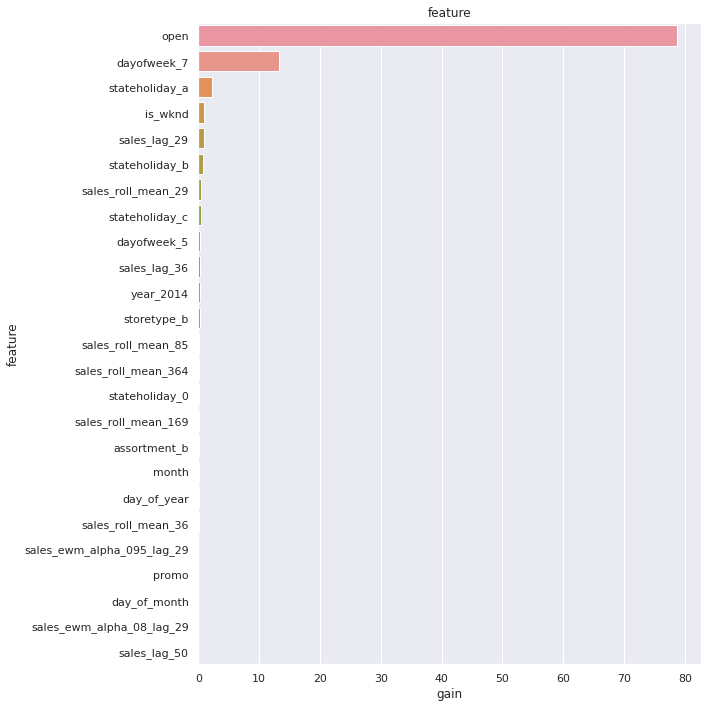

In [ ]:
plot_lgb_importances(model, num=30, plot=True)

#### **5.2. Prophet**

In [ ]:
# Installation
!pip install pystan==2.19.1.1

In [ ]:
!pip install prophet

     |████████████████████████████████| 65 kB 2.3 MB/s 
     |████████████████████████████████| 49 kB 4.8 MB/s 
     |████████████████████████████████| 216 kB 19.3 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6639933 sha256=24231b066ca8980218539e661122413741edb7da0b301afe4fb51fb245a8803d
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [ ]:
# https://www.kaggle.com/elenapetrova/time-series-analysis-and-forecasts-with-prophet
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
# remove closed stores and those with no sales
dfp = train_df[(train_df["Open"] != 0) & (train_df['Sales'] != 0)]

In [ ]:
# sales for the store number 1 (StoreType C)
sales = dfp[dfp.Store == 1].loc[:, ['Date', 'Sales']]

In [ ]:
# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

In [ ]:
# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [ ]:
# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


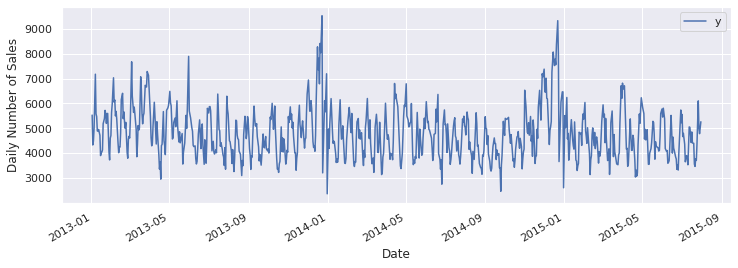

In [ ]:
# plot daily sales
ax = sales.set_index('ds').plot(figsize = (12, 4))
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

#### **5.2.1. Modeling Holidays**

In [ ]:
# create holidays dataframe
state_dates = dfp[(dfp.StateHoliday == 'a') | (dfp.StateHoliday == 'b') & (dfp.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = dfp[dfp.SchoolHoliday == 1].loc[:, 'Date'].values

In [ ]:
state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

In [ ]:
holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [ ]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
from prophet import Prophet
my_model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
my_model.fit(sales)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# dataframe that extends into future 6 weeks 
future_dates = my_model.make_future_dataframe(periods = 6*7)

print("First week to forecast.")
future_dates.tail(7)

First week to forecast.


,ds
816,2015-09-05
817,2015-09-06
818,2015-09-07
819,2015-09-08
820,2015-09-09
821,2015-09-10
822,2015-09-11


In [ ]:
# predictions
forecast = my_model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
816,2015-09-05,4092.645309,2444.581176,5637.491366
817,2015-09-06,4087.376010,2467.771370,5842.448158
818,2015-09-07,4162.186358,2571.278369,5792.250885
819,2015-09-08,3664.587720,2107.715301,5209.997069
820,2015-09-09,3551.399919,1965.769704,5172.547594
821,2015-09-10,3462.872829,1949.159152,5069.191958
822,2015-09-11,3717.538164,1991.079942,5250.504679


In [ ]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

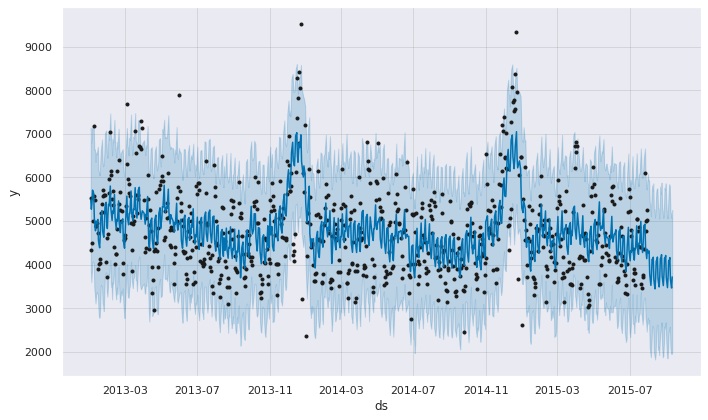

In [ ]:
# visualizing predicions
my_model.plot(forecast);

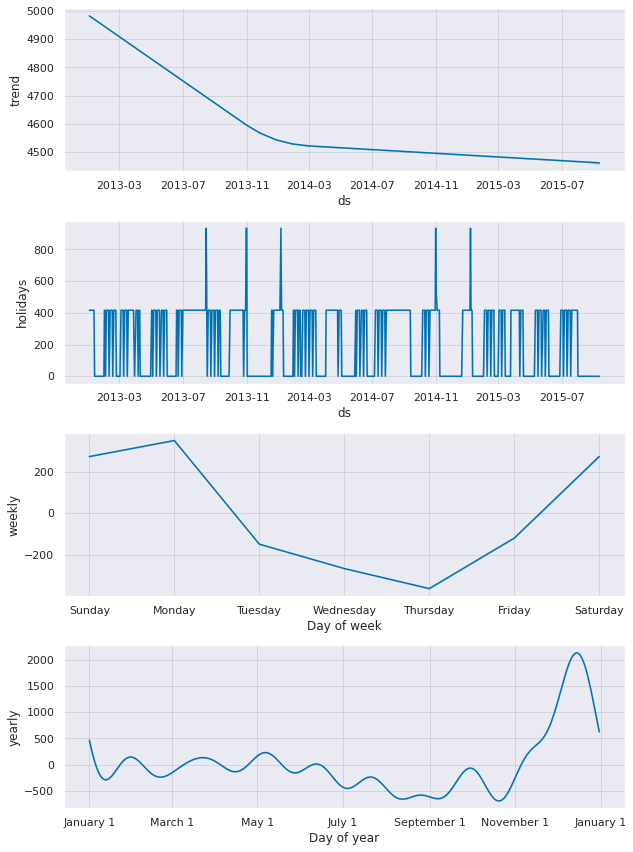

In [ ]:
my_model.plot_components(forecast);

#### **ANOTHER IMPLEMENTATION**

In [ ]:
# https://github.com/nicknochnack/TimeSeriesForecastingProphet/blob/main/Facebook%20Prophet.ipynb
m = Prophet(interval_width=0.95, daily_seasonality=True)
model = m.fit(sales)

In [ ]:
# Forecast
future = m.make_future_dataframe(periods=6*7,freq='D')
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-02,5474.928609,3968.137063,7180.857153,5474.928609,5474.928609,136.573140,136.573140,136.573140,-208.305595,-208.305595,-208.305595,-199.837745,-199.837745,-199.837745,544.716480,544.716480,544.716480,0.0,0.0,0.0,5611.501748
1,2013-01-03,5473.256614,3636.060625,7081.152153,5473.256614,5473.256614,-82.414908,-82.414908,-82.414908,-208.305595,-208.305595,-208.305595,-289.008836,-289.008836,-289.008836,414.899523,414.899523,414.899523,0.0,0.0,0.0,5390.841706
2,2013-01-04,5471.584619,3875.026386,7155.446928,5471.584619,5471.584619,48.125235,48.125235,48.125235,-208.305595,-208.305595,-208.305595,-34.245837,-34.245837,-34.245837,290.676667,290.676667,290.676667,0.0,0.0,0.0,5519.709853
3,2013-01-05,5469.912624,4047.351390,7277.782102,5469.912624,5469.912624,136.256894,136.256894,136.256894,-208.305595,-208.305595,-208.305595,171.078533,171.078533,171.078533,173.483956,173.483956,173.483956,0.0,0.0,0.0,5606.169517
4,2013-01-07,5466.568634,3949.992121,7272.148876,5466.568634,5466.568634,165.072738,165.072738,165.072738,-208.305595,-208.305595,-208.305595,408.262271,408.262271,408.262271,-34.883937,-34.883937,-34.883937,0.0,0.0,0.0,5631.641372


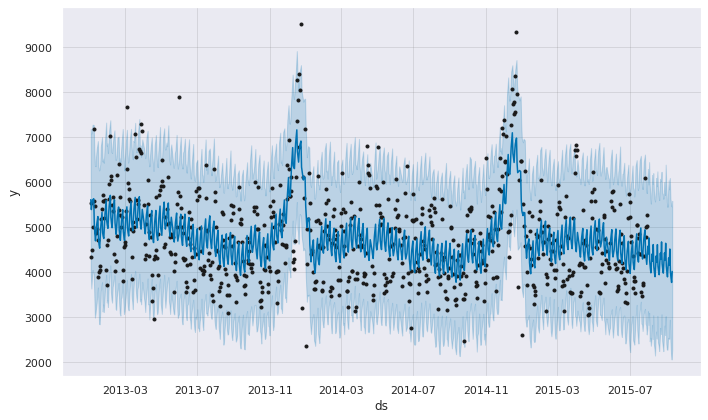

In [ ]:
plot1 = m.plot(forecast)

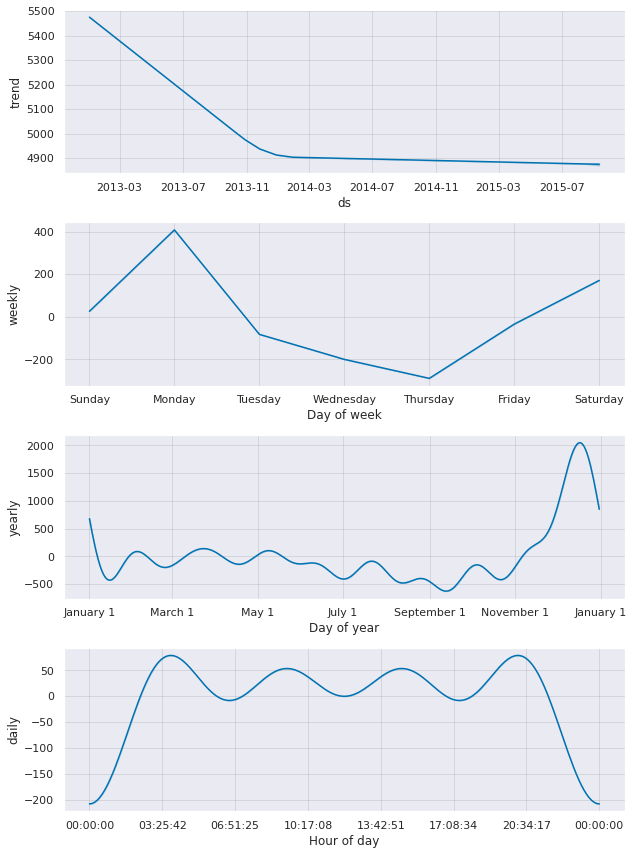

In [ ]:
plt2 = m.plot_components(forecast)